Data analysis.

We are going to analyze the data stored in the dataframe 'final_df', which is located in the directory 'data_new'. The reader can check the jupyter notebook 'data_preparation' to find out how 'final_df' was built. Many columns in that dataframe have self-explanatory titles. Other columns have descriptions located in the nested dictionary 'final_dic' (a dictionary of dictionaries). In reality, for confidentiality reason, 'final_dic' is not made publicly available. Instead, only its censored version 'final_dic_pub' is made publicly available. To start, let's import the relevant modules.

In [1]:
## Relevant modules.
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from datetime import datetime
from datetime import date
from datetime import timedelta
from itertools import combinations
from collections import defaultdict

The files stored in the directory 'data_new' are actually csv files. We are going to use them to recover 'final_df' and 'final_dic_pub'.  
ATTENTION! THE RECOVERING OF 'final_dic' IS FOR PRIVATE USE ONLY!

In [2]:
## Recovering 'final_df'.
final_df = pd.read_csv('data_new/final_df.csv', 
                       index_col=0, 
                       header=0, 
                       low_memory=False,
                       keep_default_na=False,
                       na_values='')

with open('data_new/final_df_dtypelist.csv', newline='') as to_read:
    reader = csv.reader(to_read)
    data = list(reader)
    final_df_dtypedic = dict(data)

for i in final_df.columns:
    final_df[i] = final_df[i].astype(final_df_dtypedic[i])

## Recovering 'final_dic_pub'.
final_dic_pub_df = pd.read_csv('data_new/final_dic_pub_df.csv',
                               index_col=0, 
                               header=0, 
                               low_memory=False,
                               keep_default_na=False,
                               na_values='')

final_dic_pub = {}
for key in final_dic_pub_df.columns:
    value = final_dic_pub_df[key].dropna().to_dict()
    final_dic_pub.update({key: value})
    
## ATTENTION! FOR PRIVATE USE ONLY!
## Recovering 'final_dic'.
final_dic_df = pd.read_csv('data_new/final_dic_df.csv',
                               index_col=0, 
                               header=0, 
                               low_memory=False,
                               keep_default_na=False,
                               na_values='')

final_dic = {}
for key in final_dic_df.columns:
    value = final_dic_df[key].dropna().to_dict()
    final_dic.update({key: value})

In order to keep things safe and simple, let's work with a copy of 'final_df' called just 'df'.  
Moreover, let's make a copy of 'final_dic_pub' called just 'df_dic_pub'.  
ATTENTION! THE COPY OF 'final_dic' CALLED 'df_dic' IS FOR PRIVATE USE ONLY!

In [3]:
df = final_df.copy()
df_dic_pub = final_dic_pub.copy()

print(df.info(verbose=True, null_counts=True))
print()
print("'df_dic_pub' keys:")
print(df_dic_pub.keys())

## ATTENTION! FOR PRIVATE USE ONLY!
df_dic = final_dic.copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56640 entries, 132755 to 295082
Data columns (total 112 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   age               9051 non-null   Int64         
 1   age_range         9051 non-null   object        
 2   country           41135 non-null  object        
 3   us_region         40599 non-null  object        
 4   us_zipcode        40529 non-null  object        
 5   firm_id           56425 non-null  float64       
 6   firm_type         56425 non-null  float64       
 7   firm_loc          56425 non-null  object        
 8   contact_date      56425 non-null  datetime64[ns]
 9   visit_datetime    56425 non-null  datetime64[ns]
 10  status_cancel     56425 non-null  float64       
 11  source_online     56425 non-null  float64       
 12  payment_cc        56425 non-null  float64       
 13  guests            56425 non-null  float64       
 14  guests_in      

Let's take a closer look at some variables to better understand them and perhaps detect possible problems.  
There are price, quantity and revenue for 27 addons (addons 01 to 27).  
Indeed, revenue equals to price*quantity for every single addon. No problems there.

In [4]:
check_rev_addons = []
for i in range(1,28):
    addon = 'addon_'+f'{i:02d}'
    check_rev = df[addon+'_rev'].equals((df[addon+'_price']*df[addon+'_quant']).round(2))
    check_rev_addons.append(check_rev)
print('Is revenue equal to price*quantity for every single addon from 01 to 27?')
print(all(check_rev_addons))

Is revenue equal to price*quantity for every single addon from 01 to 27?
True


'tot_rev_addons' should supposedly be equal to the horizontal sum of revenues for addons 01 to 27.  
That is true for 56320 out of 56640 entries (56105 trues + 215 NANs=zeros).  
But that is not true for 320 out of 56640 entries.  
All those 320 entries show 'tot_rev_addons' larger than the horizontal sum of revenues.  
More about that next.

In [5]:
col_rev = list(filter(lambda x: x[6:8].isdigit() and x.endswith('_rev'),
                        df.columns))
df['tot_rev_addons_alt'] = df[col_rev].sum(axis=1, skipna=True).round(2)

print("'tot_rev_addons_alt' is the horizontal sum of revenues for addons 01 to 27.")
print("'tot_rev_addons_alt' is rounded to the nearest hundredth.")
print("'tot_rev_addons_alt' is a temporary column to check 'tot_rev_addons'.")
print()
print("Is 'tot_rev_addons' equal to 'tot_rev_addons_alt'?")
print(df['tot_rev_addons'].equals(df['tot_rev_addons_alt']))

f0 = df['tot_rev_addons'] == df['tot_rev_addons_alt']
f1 = df['tot_rev_addons'] != df['tot_rev_addons_alt']
f2 = df['tot_rev_addons'].isna()
f3 = df['tot_rev_addons_alt'] == 0
f4 = df['tot_rev_addons'].notna()
f5 = df['tot_rev_addons'] > df['tot_rev_addons_alt']

print("Number of instances where 'tot_rev_addons' is equal to 'tot_rev_addons_alt':")
print(len(df.loc[f0, ['tot_rev_addons', 'tot_rev_addons_alt']]))

print("Number of instances where 'tot_rev_addons' is not equal to 'tot_rev_addons_alt':")
print(len(df.loc[f1, ['tot_rev_addons', 'tot_rev_addons_alt']]))

print("- Because 'tot_rev_addons' is NAN and 'tot_rev_addons_alt' is 0, not a issue:")
print(len(df.loc[f1 & f2 & f3, ['tot_rev_addons', 'tot_rev_addons_alt']]))

print("- Because 'tot_rev_addons' is larger than 'tot_rev_addons_alt', maybe a issue:")
print(len(df.loc[f1 & f4 & f5, ['tot_rev_addons', 'tot_rev_addons_alt']]), end=' ')

df_temp = df.loc[f1 & f4 & f5, ['tot_rev_addons', 'tot_rev_addons_alt']]
df_temp['diff'] = df_temp['tot_rev_addons'] - df_temp['tot_rev_addons_alt']
minimum = round(min(df_temp['diff']),0)
maximum = round(max(df_temp['diff']),0)
print('(minimum difference: ', minimum, '; maximum difference: ', maximum, ')', sep='')

df.drop(columns=['tot_rev_addons_alt'], inplace=True)

'tot_rev_addons_alt' is the horizontal sum of revenues for addons 01 to 27.
'tot_rev_addons_alt' is rounded to the nearest hundredth.
'tot_rev_addons_alt' is a temporary column to check 'tot_rev_addons'.

Is 'tot_rev_addons' equal to 'tot_rev_addons_alt'?
False
Number of instances where 'tot_rev_addons' is equal to 'tot_rev_addons_alt':
56105
Number of instances where 'tot_rev_addons' is not equal to 'tot_rev_addons_alt':
535
- Because 'tot_rev_addons' is NAN and 'tot_rev_addons_alt' is 0, not a issue:
215
- Because 'tot_rev_addons' is larger than 'tot_rev_addons_alt', maybe a issue:
320 (minimum difference: 3.0; maximum difference: 300.0)


'tot_quant_addons' should supposedly be equal to the horizontal sum of quantities for addons 01 to 27.  
Again, that is true for 56320 out of 56640 entries (56105 trues + 215 NANs=zeros).  
And again, that is not true for 320 out of 56640 entries.  
All those 320 entries show 'tot_quant_addons' larger than the horizontal sum of quantities.  
  
Therefore, the reason 320 entries of 'tot_rev_addons' are larger than expected is because 320 entries of 'tot_quant_addons' are larger than expected. This can be a mistake or an indication that other types of addons exist but were not specified in the original database. We will assume the latter and maintain those 320 entries. Anyway, 320 is a small portion of 56640: a little more than 0.5% of the whole sample.

In [6]:
col_quant = list(filter(lambda x: x[6:8].isdigit() and x.endswith('_quant'),
                        df.columns))
df['tot_quant_addons_alt'] = df[col_quant].sum(axis=1, skipna=True)

print("'tot_quant_addons_alt' is the horizontal sum of quantities for addons 01 to 27.")
print("'tot_quant_addons_alt' is a temporary column to check 'tot_quant_addons'.")
print()
print("Is 'tot_quant_addons' equal to 'tot_quant_addons_alt'?")
print(df['tot_quant_addons'].equals(df['tot_quant_addons_alt']))

f0 = df['tot_quant_addons'] == df['tot_quant_addons_alt']
f1 = df['tot_quant_addons'] != df['tot_quant_addons_alt']
f2 = df['tot_quant_addons'].isna()
f3 = df['tot_quant_addons_alt'] == 0
f4 = df['tot_quant_addons'].notna()
f5 = df['tot_quant_addons'] > df['tot_quant_addons_alt']

print("Number of instances where 'tot_quant_addons' is equal to 'tot_quant_addons_alt':")
print(len(df.loc[f0, ['tot_quant_addons', 'tot_quant_addons_alt']]))

print("Number of instances where 'tot_quant_addons' is not equal to 'tot_quant_addons_alt':")
print(len(df.loc[f1, ['tot_quant_addons', 'tot_quant_addons_alt']]))

print("- Because 'tot_quant_addons' is NAN and 'tot_quant_addons_alt' is 0, not a issue:")
print(len(df.loc[f1 & f2 & f3, ['tot_quant_addons', 'tot_quant_addons_alt']]))

print("- Because 'tot_quant_addons' is larger than 'tot_quant_addons_alt', maybe a issue:")
print(len(df.loc[f1 & f4 & f5, ['tot_quant_addons', 'tot_quant_addons_alt']]), end=' ')

df_temp = df.loc[f1 & f4 & f5, ['tot_quant_addons', 'tot_quant_addons_alt']]
df_temp['diff'] = df_temp['tot_quant_addons'] - df_temp['tot_quant_addons_alt']
minimum = round(min(df_temp['diff']),0)
maximum = round(max(df_temp['diff']),0)
print('(minimum difference: ', minimum, '; maximum difference: ', maximum, ')', sep='')

df.drop(columns=['tot_quant_addons_alt'], inplace=True)

'tot_quant_addons_alt' is the horizontal sum of quantities for addons 01 to 27.
'tot_quant_addons_alt' is a temporary column to check 'tot_quant_addons'.

Is 'tot_quant_addons' equal to 'tot_quant_addons_alt'?
False
Number of instances where 'tot_quant_addons' is equal to 'tot_quant_addons_alt':
56105
Number of instances where 'tot_quant_addons' is not equal to 'tot_quant_addons_alt':
535
- Because 'tot_quant_addons' is NAN and 'tot_quant_addons_alt' is 0, not a issue:
215
- Because 'tot_quant_addons' is larger than 'tot_quant_addons_alt', maybe a issue:
320 (minimum difference: 1.0; maximum difference: 22.0)


'tot_rev' should supposedly be equal to 'fee' * 'guests' + 'tot_rev_addons'.  
That is true for 56638 out of 56640 entries (56423 trues + 215 NANs=NANs).  
But that is not true for 2 out of 56640 entries, just a tiny fraction of the total.  
Those 2 entries show 'tot_rev' larger than expected, but the differences are less than a dollar, so their removal is not necessary.

In [7]:
df['tot_rev_alt'] = ((df['fee']*df['guests'])+df['tot_rev_addons']).round(0)

print("'tot_rev_alt' is 'fee' * 'guests' + 'tot_rev_addons'.")
print("'tot_rev_alt' is rounded to the nearest unit.")
print("'tot_rev_alt' is a temporary column to check 'tot_rev'.")
print()
print("Is 'tot_rev' equal to 'tot_rev_alt'?")
print(df['tot_rev'].equals(df['tot_rev_alt']))

f0 = df['tot_rev'].round(0) == df['tot_rev_alt']
f1 = df['tot_rev'].round(0) != df['tot_rev_alt']
f2 = df['tot_rev'].isna()
f3 = df['tot_rev_alt'].isna()
f4 = df['tot_rev'].notna()
f5 = df['tot_rev'] > df['tot_rev_alt']

print("Number of instances where 'tot_rev' is equal to 'tot_rev_alt':")
print(len(df.loc[f0, ['tot_rev', 'tot_rev_alt']]))

print("Number of instances where 'tot_rev' is not equal to 'tot_rev_alt':")
print(len(df.loc[f1, ['tot_rev', 'tot_rev_alt']]))

print("- Because 'tot_rev' is NAN and 'tot_rev_alt' is NAN, not a issue:")
print(len(df.loc[f1 & f2 & f3, ['tot_rev', 'tot_rev_alt']]))

print("- Because 'tot_rev' is larger than 'tot_rev_alt', maybe a issue:")
print(len(df.loc[f1 & f4 & f5, ['tot_rev', 'tot_rev_alt']]), end=' ')

df_temp = df.loc[f1 & f4 & f5, ['tot_rev', 'tot_rev_alt']]
df_temp['diff'] = df_temp['tot_rev'] - df_temp['tot_rev_alt']
minimum = round(min(df_temp['diff']),2)
maximum = round(max(df_temp['diff']),2)
print('(minimum difference: ', minimum, '; maximum difference: ', maximum, ')', sep='')

df.drop(columns=['tot_rev_alt'], inplace=True)

'tot_rev_alt' is 'fee' * 'guests' + 'tot_rev_addons'.
'tot_rev_alt' is rounded to the nearest unit.
'tot_rev_alt' is a temporary column to check 'tot_rev'.

Is 'tot_rev' equal to 'tot_rev_alt'?
False
Number of instances where 'tot_rev' is equal to 'tot_rev_alt':
56423
Number of instances where 'tot_rev' is not equal to 'tot_rev_alt':
217
- Because 'tot_rev' is NAN and 'tot_rev_alt' is NAN, not a issue:
215
- Because 'tot_rev' is larger than 'tot_rev_alt', maybe a issue:
2 (minimum difference: 0.5; maximum difference: 0.52)


There are 56425 non-null entries for 'firm_id', which is the variable that identifies the 11 firms in our sample. However, those 56426 entries are not equally distributed among the 11 firms. For example, 'firm_id' 38850 has 15374 entries while 'firm_id' 38433 has only 113 entries. Moreover, some variables expected to have the same number of non-null entries as 'firm_id' actually have less than 56425 non-null entries. They are showed in the cell below. Variables about feedback, questions (those starting with 'q') and addons (those starting with 'addons') are not expected to have the same number of non-null entries as 'firm_id', and so are not included in the cell below.

The biggest problem is 'age' (and the correlated 'age_range'), which has 9051 entries unequally divided between only two 'firm_id'. Therefore, if we wanted to include 'age' in our analysis, we would have information available only for 'firm_id' 40638 and 41065, and the data would be distributed very unevenly between the two. 

Another problematic variable in terms of non-null entries available is 'guests_in', which shows the number of guests (i.e., clients with booked visits) that actually checked in. The information availability changes a lot among firms. For example, 'firm_id' 34700, with 3736 non-null entries, only has 1 non-null entry for 'guests_in'.

In [8]:
list_variables = ['firm_id', 'age', 'country', 'us_region', 'us_zipcode', 'guests_in']
df_groupby = df.groupby(['firm_id'])[list_variables].count()
df_groupby.rename(columns={'firm_id': 'firm_id_count'}, inplace=True)
table = df_groupby.sort_values(by='firm_id_count', ascending=False)
from tabulate import tabulate
print(tabulate(table, headers='keys', tablefmt='pretty'))

+---------+---------------+------+---------+-----------+------------+-----------+
| firm_id | firm_id_count | age  | country | us_region | us_zipcode | guests_in |
+---------+---------------+------+---------+-----------+------------+-----------+
| 38850.0 |     15374     |  0   |  6239   |   6201    |    6200    |   10171   |
| 40638.0 |     11738     | 8612 |  9374   |   9016    |    9005    |   1382    |
| 26742.0 |     10266     |  0   |  8082   |   8014    |    7983    |   9655    |
| 36146.0 |     8986      |  0   |  8067   |   8054    |    8043    |   8084    |
| 34700.0 |     3736      |  0   |  3722   |   3698    |    3689    |     1     |
| 3254.0  |     2455      |  0   |  2259   |   2255    |    2254    |   2106    |
| 38204.0 |     1457      |  0   |  1256   |   1240    |    1239    |   1234    |
| 38852.0 |     1263      |  0   |  1214   |   1207    |    1204    |   1024    |
| 41065.0 |      558      | 439  |   445   |    442    |    441     |    413    |
| 40664.0 |     

If we ditch 'age' and 'guests_in', and then eliminate all null entries, we have the following result in terms of non-null entries (see cell below). We can now observe that 'firm_id' 40638, 36146 and 26742 have a high and similar amount of data. As a first analysis approach, we are going to work with these three firms only.

In [9]:
list_variables = ['firm_id', 'country', 'us_region', 'us_zipcode']
df_nonnull = df[list_variables].dropna()
df_groupby = df_nonnull.groupby(['firm_id'])[list_variables].count()
df_groupby.rename(columns={'firm_id': 'firm_id_count'}, inplace=True)
print(df_groupby.sort_values(by='firm_id_count', ascending=False))

         firm_id_count  country  us_region  us_zipcode
firm_id                                               
40638.0           9005     9005       9005        9005
36146.0           8043     8043       8043        8043
26742.0           7983     7983       7983        7983
38850.0           6200     6200       6200        6200
34700.0           3689     3689       3689        3689
3254.0            2254     2254       2254        2254
38204.0           1239     1239       1239        1239
38852.0           1204     1204       1204        1204
41065.0            441      441        441         441
40664.0            368      368        368         368
38433.0            103      103        103         103


Just out of curiosity, here is a brief analysis of 'age' involving 'firm_id' 40638 and 41065. Two tests of means were made. In the first test, the hypothesis H0 says that difference in means of 'age' for different 'firm_id' is by chance, meaning that the means actually come from the same distribution. In the second test, H0 says that there is no difference in means of 'age' for different 'firm_id'. Both tests do not reject H0. Therefore, as the graph below was already suggesting, the distribution of 'age' for 'firm_id' 40638 and 41065 may in fact be basically the same. It is important to keep in mind that the smaller data available for 'firm_id' 41065 may have an impact in the results as indicated by the larger confidence interval for that firm in the second test (less data equal to more uncertainty). That is why would be desirable to have a balanced amount of non-null entries among the firms.

In [10]:
## Some definitions to use in the first comparison of means.
def diff_of_means(data_1, data_2):
    diff = np.mean(data_1) - np.mean(data_2)
    return diff

def permutation_sample(data_1, data_2):
    data = np.concatenate((data_1, data_2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data_1)]
    perm_sample_2 = permuted_data[len(data_1):]
    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

## Some more definitions to use in the second comparison of means.
def bootstrap_replicate_1d(data, func): 
    return func(np.random.choice(data, len(data)))

def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for _ in range(size)])

def bs_95_ci(data, func, size=1):
    return np.percentile(draw_bs_reps(data, func, size), [2.5, 97.5])

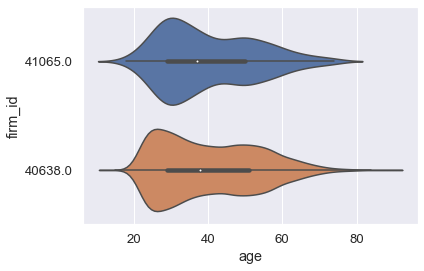

First comparison of means.
H0: difference in means of 'age' for different 'firm_id' is by chance.
The meaning of H0 is that the means actually come from the same distribution.
Category: firm_id
p-value for H0 in the case of 40638.0 vs. 41065.0 is 0.452
H0 is not rejected.

Second comparison of means.
H0: there is no difference in means of 'age' for different 'firm_id'.
95% c. i. if 40638.0 = [39.98071296 40.53901823]
95% c. i. if 41065.0 = [39.01822323 41.39179954]


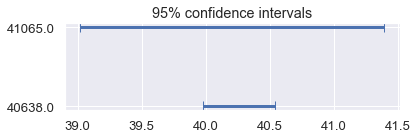

In [11]:
df_age = df[['firm_id','age']].dropna()
df_age.sort_values(by=['firm_id'], ascending=False, inplace=True)
df_age['age'] = df_age['age'].astype('float')

sns.set(font_scale=1.2)
_ = sns.violinplot(x='age', y='firm_id', data=df_age, orient='h', 
                   order=df_age['firm_id'].unique())
plt.show()

## First comparison of means.
np.random.seed(10)
print("First comparison of means.")
print("H0: difference in means of 'age' for different 'firm_id' is by chance.")
print("The meaning of H0 is that the means actually come from the same distribution.")

categories = ['firm_id']
for i in categories:
    print('Category:',i)
    names = np.unique(df_age[i])
    comb = list(combinations(names, 2))
    for j in comb:
        data_1 = df_age['age'][df_age[i]==j[0]]
        data_2 = df_age['age'][df_age[i]==j[1]]
        empirical_diff_means = diff_of_means(data_1, data_2)
        perm_replicates = draw_perm_reps(data_1, data_2, diff_of_means, size=1000)
        if empirical_diff_means >= 0:
            p = np.sum(perm_replicates >= empirical_diff_means)/len(perm_replicates)
        else:
            p = np.sum(perm_replicates <= empirical_diff_means)/len(perm_replicates)
        print('p-value for H0 in the case of',j[0],'vs.',j[1],'is',p)
        if p > 0.025:
            print('H0 is not rejected.')
        else:
            print('H0 is rejected.')

## Second comparison of means.
print("\nSecond comparison of means.")
print("H0: there is no difference in means of 'age' for different 'firm_id'.")            

lst = []
for i in np.unique(df_age['firm_id']):
    data = df_age['age'][df_age['firm_id']==i]
    ci_mean = bs_95_ci(data, np.mean, size=10000)
    lst.append([i, ci_mean[0], ci_mean[1]])
    print('95% c. i. if',i,'=',ci_mean)
df0 = pd.DataFrame(lst)
df0.columns = ['firm_id','ci_min','ci_max']
df0['ci_mid'] = (df0['ci_min'] + df0['ci_max'])/2
df0['half_size'] = df0['ci_mid'] - df0['ci_min']
plt.figure(figsize=(6,1.6))
_ = plt.errorbar(df0['ci_mid'], df0['firm_id'].astype('str'), xerr=df0['half_size'],
                 ls='', elinewidth=3, capsize=5)
plt.title('95% confidence intervals')
plt.show()

As we discussed earlier, in fact we are going to work only with 'firm_id' 40638, 36146 and 26742 so as to have a high and somewhat balanced amount of non-null entries among the firms. We can see below that firms 40638 and 36146 are type 1 whereas firm 26742 is type 2. Firm 40638 is located in Saint Louis, MO. Firm 36146 is located in San Francisco, CA. Firm 26742 is located in Denver, CO. After having selected the firms, we trimmed the dataframe 'df' by:


- ditching rows related to 'firm_id' other than 40638, 36146 and 26742.
- ditching rows with null entries based on columns expected to have equal number of non-null entries ('firm_id', 'country', 'us_region', 'us_zipcode').
- ditching 'age', 'age_range' and 'guests_in' columns due to the reasons explained before.
- ditching the unnecessary 'merge_questions' and 'merge_addons' columns.

The result is as follows below. As expected (as seen before), firm 40638 now has 9005 non-null entries, 36146 has 8043 non-null entries and 26742 has 7983 non-null entries. It is worth remembering that the original dataframe can be recovered any time if necessary by using the command df = final_df.copy().

In [12]:
## Just to make sure we are starting with the original dataframe before trimming it.
df = final_df.copy()

list_firms = [40638, 36146, 26742]
list_variables = ['firm_id', 'country', 'us_region', 'us_zipcode']
df = df[df['firm_id'].isin(list_firms)]
df = df.dropna(subset=list_variables)
df.drop(columns=['age', 'age_range', 'guests_in'], inplace=True)
df.drop(columns=['merge_questions', 'merge_addons'], inplace=True)

df_groupby_01 = df.groupby(['firm_id'])[['firm_type', 'firm_loc']].agg(pd.Series.mode)
print(df_groupby_01.sort_index(ascending=False))
print()

df_groupby_02 = df.groupby(['firm_id'])[list_variables].count()
df_groupby_02.rename(columns={'firm_id': 'firm_id_count'}, inplace=True)
print(df_groupby_02.sort_values(by='firm_id_count', ascending=False))
print()

print(df.info(verbose=True, null_counts=True))

         firm_type             firm_loc
firm_id                                
40638.0        1.0    US_MO_Saint Louis
36146.0        1.0  US_CA_San Francisco
26742.0        2.0        US_CO_Denver,

         firm_id_count  country  us_region  us_zipcode
firm_id                                               
40638.0           9005     9005       9005        9005
36146.0           8043     8043       8043        8043
26742.0           7983     7983       7983        7983

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25031 entries, 132755 to 187154
Data columns (total 107 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   country           25031 non-null  object        
 1   us_region         25031 non-null  object        
 2   us_zipcode        25031 non-null  object        
 3   firm_id           25031 non-null  float64       
 4   firm_type         25031 non-null  float64       
 5   firm_loc          25031 

It is easy to notice now that some columns related to questions (those starting with 'q') and addons (those starting with 'addons') only have null values. They refer to questions and addons that are not relevant to the three firms we are currently investigating. Thus, they can be deleted.

In [13]:
columns_to_delete = df.columns[df.isna().all()].tolist()
df.drop(columns=columns_to_delete, inplace=True)
print(df.info(verbose=True, null_counts=True))
indexes_total = len(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25031 entries, 132755 to 187154
Data columns (total 46 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   country           25031 non-null  object        
 1   us_region         25031 non-null  object        
 2   us_zipcode        25031 non-null  object        
 3   firm_id           25031 non-null  float64       
 4   firm_type         25031 non-null  float64       
 5   firm_loc          25031 non-null  object        
 6   contact_date      25031 non-null  datetime64[ns]
 7   visit_datetime    25031 non-null  datetime64[ns]
 8   status_cancel     25031 non-null  float64       
 9   source_online     25031 non-null  float64       
 10  payment_cc        25031 non-null  float64       
 11  guests            25031 non-null  float64       
 12  fee               25031 non-null  float64       
 13  discount          25031 non-null  float64       
 14  tot_quant_addons

Among the columns related to questions and feedback with data available, the most interesting in terms of amount of non-null entries are 'q1_bef' and 'q2' (see details below). The column 'q1_aft' is also interesting as a follow-up of column 'q1_bef', despite its high number of null entries.

When comparing each variable between firms, the distributions of 'q1_bef' and 'q1_aft' are not equal but somehow similar whereas the distributions of 'q2' are quite different. In particular, when contrasting 'q1_bef' and 'q1_aft', it is possible to notice that they don't mirror each other, meaning that visits may have an impact on clients.  

Between 6.79% and 1.79% of the entries for 'q1_bef' are null depending on the 'firm_id' (in total, 4.08% of the entries for 'q1_bef' are null). Between 63.79% and 62.47% of the entries for 'q1_aft' are null depending on the 'firm_id' (in total, 63.28% of the entries for 'q1_aft' are null). Between 5.39% and 1.79% of the entries for 'q2' are null depending on the 'firm_id' (in total, 3.58% of the entries for 'q2' are null).

Amount of non-null entries:
         firm_id_count  q1_bef  q1_aft    q2    q3  feedback
firm_id                                                     
40638.0           9005    8394    3261  8520  9001      2227
36146.0           8043    7899    2934  7899     0      1679
26742.0           7983    7717    2996  7717     0       385

Looking more closely at three variables of interest:
- q1_bef: likelihood to recommend our product before visit on scale 0-10
- q1_aft: likelihood to recommend our product after visit on scale 0-10
- q2: how often did you use our product in the past year?
  0 never
  1 occasionally
  2 at least once a month
  3 at least once a week


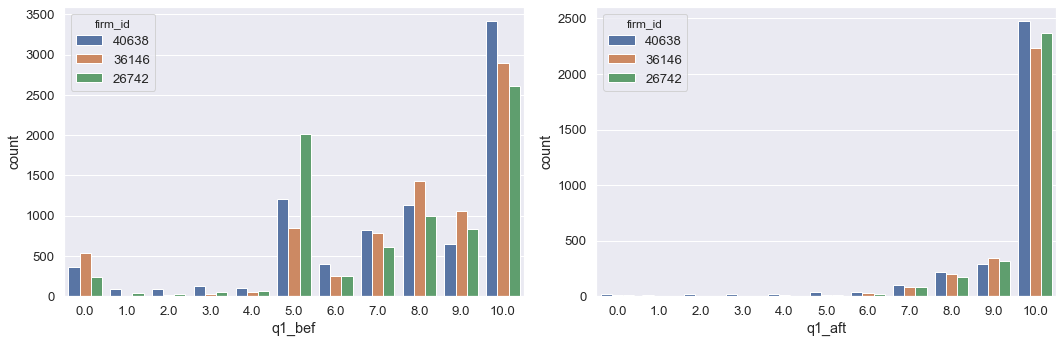

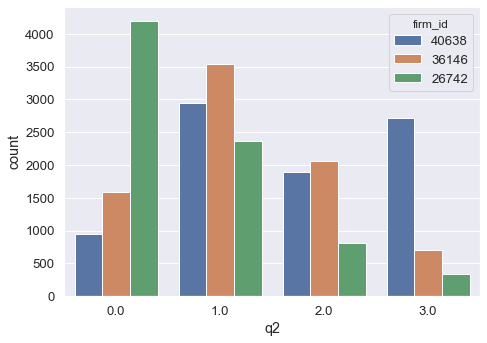

Amount of null entries in 'q1_bef', 'q1_aft' and 'q2':

firm_id 40638
- 611 entries for q1_bef are null.
  6.79% of the entries for q1_bef are null.
- 5744 entries for q1_aft are null.
  63.79% of the entries for q1_aft are null.
- 485 entries for q2 are null.
  5.39% of the entries for q2 are null.

firm_id 36146
- 144 entries for q1_bef are null.
  1.79% of the entries for q1_bef are null.
- 5109 entries for q1_aft are null.
  63.52% of the entries for q1_aft are null.
- 144 entries for q2 are null.
  1.79% of the entries for q2 are null.

firm_id 26742
- 266 entries for q1_bef are null.
  3.33% of the entries for q1_bef are null.
- 4987 entries for q1_aft are null.
  62.47% of the entries for q1_aft are null.
- 266 entries for q2 are null.
  3.33% of the entries for q2 are null.

In total
- 1021 entries for q1_bef are null.
  4.08% of the entries for q1_bef are null.
- 15840 entries for q1_aft are null.
  63.28% of the entries for q1_aft are null.
- 895 entries for q2 are null.
  3.

In [14]:
list_variables = ['firm_id','q1_bef', 'q1_aft', 'q2', 'q3', 'feedback']
df_groupby = df.groupby(['firm_id'])[list_variables].count()
df_groupby.rename(columns={'firm_id': 'firm_id_count'}, inplace=True)
print('Amount of non-null entries:')
print(df_groupby.sort_values(by='firm_id_count', ascending=False))
print()
print('Looking more closely at three variables of interest:')
print('-', 'q1_bef:', df_dic_pub['q1_bef']['question'])
print('-', 'q1_aft:', df_dic_pub['q1_aft']['question'])
print('-', 'q2:', df_dic_pub['q2']['question'])
for i in df_dic_pub['q2']:
    if i != 'question':
        print(' ', i, df_dic_pub['q2'][i])

fig, ax = plt.subplots(1, 2, figsize=(15,5))
_ = sns.countplot(x='q1_bef', hue='firm_id', hue_order=[40638,36146,26742],
                  data=df[['firm_id','q1_bef']].astype('float'), ax=ax[0])
_ = sns.countplot(x='q1_aft', hue='firm_id', hue_order=[40638,36146,26742],
                  data=df[['firm_id','q1_aft']].astype('float'), ax=ax[1])                                 
plt.tight_layout()                   
plt.show()

fig, ax = plt.subplots(figsize=(7,5))
_ = sns.countplot(x='q2', hue='firm_id', hue_order=[40638,36146,26742],
                  data=df[['firm_id','q2']].astype('float'))                                 
plt.tight_layout()                   
plt.show()

print("Amount of null entries in 'q1_bef', 'q1_aft' and 'q2':")
print()
for i in [40638,36146,26742]:
    f0 = df['firm_id'] == i
    
    f1_q1_bef = df['q1_bef'].isna()
    s0_q1_bef = len(df[f0 & f1_q1_bef])
    s1_q1_bef = s0_q1_bef/len(df[f0]['q1_bef'])
    
    f1_q1_aft = df['q1_aft'].isna()
    s0_q1_aft = len(df[f0 & f1_q1_aft])
    s1_q1_aft = s0_q1_aft/len(df[f0]['q1_aft'])
    
    f1_q2 = df['q2'].isna()
    s0_q2 = len(df[f0 & f1_q2])
    s1_q2 = s0_q2/len(df[f0]['q2'])
        
    print('firm_id', i)
    print('-', s0_q1_bef, 'entries for q1_bef are null.')
    print(' ', f'{s1_q1_bef:.2%}', 'of the entries for q1_bef are null.')
    print('-', s0_q1_aft, 'entries for q1_aft are null.')
    print(' ', f'{s1_q1_aft:.2%}', 'of the entries for q1_aft are null.')
    print('-', s0_q2, 'entries for q2 are null.')
    print(' ', f'{s1_q2:.2%}', 'of the entries for q2 are null.')    
    print()
    
print('In total')

indexes_q1_bef_null = df[df['q1_bef'].isna()].index.tolist()
ts0_q1_bef = len(indexes_q1_bef_null)
ts1_q1_bef = ts0_q1_bef/len(df['q1_bef'])
print('-', ts0_q1_bef, 'entries for q1_bef are null.')
print(' ', f'{ts1_q1_bef:.2%}', 'of the entries for q1_bef are null.')

indexes_q1_aft_null = df[df['q1_aft'].isna()].index.tolist()
ts0_q1_aft = len(indexes_q1_aft_null)
ts1_q1_aft = ts0_q1_aft/len(df['q1_aft'])
print('-', ts0_q1_aft, 'entries for q1_aft are null.')
print(' ', f'{ts1_q1_aft:.2%}', 'of the entries for q1_aft are null.')

indexes_q2_null = df[df['q2'].isna()].index.tolist()
ts0_q2 = len(indexes_q2_null)
ts1_q2 = ts0_q2/len(df['q2'])
print('-', ts0_q2, 'entries for q2 are null.')
print(' ', f'{ts1_q2:.2%}', 'of the entries for q2 are null.')

Let's take a quick closer look at 'q1_bef' and 'q2' since they have the most amount of non-null entries. We will try to deal with 'q1_aft' later given its high number of null entries, which is a problem. In regard to question 'q1_bef', the mean answers for each firm don't come from the same distribution, but they are close to each other between 7 and 8 in a scale between 0 and 10. In regard to question 'q2', the mean answers for each firm don't come from the same distribution and are clearly different from each other taking into account the scale between 0 and 3. 

Comparing means of 'q1_bef' between firms

First comparison of means.
H0: difference in means of 'q1_bef' for different 'firm_id' is by chance.
The meaning of H0 is that the means actually come from the same distribution.
Category: firm_id
p-value for H0 in the case of 26742.0 vs. 36146.0 is 0.0
H0 is rejected.
p-value for H0 in the case of 26742.0 vs. 40638.0 is 0.0
H0 is rejected.
p-value for H0 in the case of 36146.0 vs. 40638.0 is 0.002
H0 is rejected.

Second comparison of means.
H0: there is no difference in means of 'q1_bef' for different 'firm_id'.
95% c. i. if 26742.0 = [7.4342361  7.54930997]
95% c. i. if 36146.0 = [7.72261995 7.84238828]
95% c. i. if 40638.0 = [7.60519419 7.72206338]


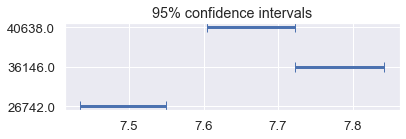


Comparing means of 'q2' between firms

First comparison of means.
H0: difference in means of 'q2' for different 'firm_id' is by chance.
The meaning of H0 is that the means actually come from the same distribution.
Category: firm_id
p-value for H0 in the case of 26742.0 vs. 36146.0 is 0.0
H0 is rejected.
p-value for H0 in the case of 26742.0 vs. 40638.0 is 0.0
H0 is rejected.
p-value for H0 in the case of 36146.0 vs. 40638.0 is 0.0
H0 is rejected.

Second comparison of means.
H0: there is no difference in means of 'q2' for different 'firm_id'.
95% c. i. if 26742.0 = [0.62964883 0.6672282 ]
95% c. i. if 36146.0 = [1.2163565  1.25471895]
95% c. i. if 40638.0 = [1.72769953 1.77089202]


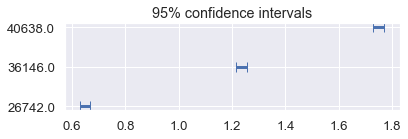

In [15]:
print('\033[1m'+"Comparing means of 'q1_bef' between firms"+'\033[0m')
print()
df_q1 = df[['firm_id','q1_bef']].dropna()
df_q1.sort_values(by=['firm_id'], ascending=False, inplace=True)
df_q1['q1_bef'] = df_q1['q1_bef'].astype('float')

## First comparison of means.
np.random.seed(10)
print("First comparison of means.")
print("H0: difference in means of 'q1_bef' for different 'firm_id' is by chance.")
print("The meaning of H0 is that the means actually come from the same distribution.")

categories = ['firm_id']
for i in categories:
    print('Category:',i)
    names = np.unique(df_q1[i])
    comb = list(combinations(names, 2))
    for j in comb:
        data_1 = df_q1['q1_bef'][df_q1[i]==j[0]]
        data_2 = df_q1['q1_bef'][df_q1[i]==j[1]]
        empirical_diff_means = diff_of_means(data_1, data_2)
        perm_replicates = draw_perm_reps(data_1, data_2, diff_of_means, size=1000)
        if empirical_diff_means >= 0:
            p = np.sum(perm_replicates >= empirical_diff_means)/len(perm_replicates)
        else:
            p = np.sum(perm_replicates <= empirical_diff_means)/len(perm_replicates)
        print('p-value for H0 in the case of',j[0],'vs.',j[1],'is',p)
        if p > 0.025:
            print('H0 is not rejected.')
        else:
            print('H0 is rejected.')

## Second comparison of means.
print("\nSecond comparison of means.")
print("H0: there is no difference in means of 'q1_bef' for different 'firm_id'.")            

lst = []
for i in np.unique(df_q1['firm_id']):
    data = df_q1['q1_bef'][df_q1['firm_id']==i]
    ci_mean = bs_95_ci(data, np.mean, size=10000)
    lst.append([i, ci_mean[0], ci_mean[1]])
    print('95% c. i. if',i,'=',ci_mean)
df0 = pd.DataFrame(lst)
df0.columns = ['firm_id','ci_min','ci_max']
df0['ci_mid'] = (df0['ci_min'] + df0['ci_max'])/2
df0['half_size'] = df0['ci_mid'] - df0['ci_min']
plt.figure(figsize=(6,1.6))
_ = plt.errorbar(df0['ci_mid'], df0['firm_id'].astype('str'), xerr=df0['half_size'],
                 ls='', elinewidth=3, capsize=5)
plt.title('95% confidence intervals')
plt.show()

print()
print('\033[1m'+"Comparing means of 'q2' between firms"+'\033[0m')
print()
df_q2 = df[['firm_id','q2']].dropna()
df_q2.sort_values(by=['firm_id'], ascending=False, inplace=True)
df_q2['q2'] = df_q2['q2'].astype('float')

## First comparison of means.
np.random.seed(10)
print("First comparison of means.")
print("H0: difference in means of 'q2' for different 'firm_id' is by chance.")
print("The meaning of H0 is that the means actually come from the same distribution.")

categories = ['firm_id']
for i in categories:
    print('Category:',i)
    names = np.unique(df_q2[i])
    comb = list(combinations(names, 2))
    for j in comb:
        data_1 = df_q2['q2'][df_q2[i]==j[0]]
        data_2 = df_q2['q2'][df_q2[i]==j[1]]
        empirical_diff_means = diff_of_means(data_1, data_2)
        perm_replicates = draw_perm_reps(data_1, data_2, diff_of_means, size=1000)
        if empirical_diff_means >= 0:
            p = np.sum(perm_replicates >= empirical_diff_means)/len(perm_replicates)
        else:
            p = np.sum(perm_replicates <= empirical_diff_means)/len(perm_replicates)
        print('p-value for H0 in the case of',j[0],'vs.',j[1],'is',p)
        if p > 0.025:
            print('H0 is not rejected.')
        else:
            print('H0 is rejected.')

## Second comparison of means.
print("\nSecond comparison of means.")
print("H0: there is no difference in means of 'q2' for different 'firm_id'.")            

lst = []
for i in np.unique(df_q2['firm_id']):
    data = df_q2['q2'][df_q2['firm_id']==i]
    ci_mean = bs_95_ci(data, np.mean, size=10000)
    lst.append([i, ci_mean[0], ci_mean[1]])
    print('95% c. i. if',i,'=',ci_mean)
df0 = pd.DataFrame(lst)
df0.columns = ['firm_id','ci_min','ci_max']
df0['ci_mid'] = (df0['ci_min'] + df0['ci_max'])/2
df0['half_size'] = df0['ci_mid'] - df0['ci_min']
plt.figure(figsize=(6,1.6))
_ = plt.errorbar(df0['ci_mid'], df0['firm_id'].astype('str'), xerr=df0['half_size'],
                 ls='', elinewidth=3, capsize=5)
plt.title('95% confidence intervals')
plt.show()

Addons are specific to each 'firm_id'. The table below shows the number of non-null entries for each addon revenue and firm. Addons 02, 10, 11 and 24 are specific to 'firm_id' 40638. Addons 01, 13, 14 and 16 are specific to 'firm_id' 36146. There is no addons for 'firm_id' 26742 and, as a result, 'firm_id' 26742 does not get revenues from  addons, meaning that its 'tot_rev_addons' is zero. In regard to the other two 'firm_id', most entries of 'tot_rev_addons' are zero or small values, with the mean not far from zero, but there are few entries with values surpassing $100.

         addon_01_rev  addon_02_rev  addon_10_rev  addon_11_rev  addon_13_rev  \
firm_id                                                                         
40638.0             0           522            70            14             0   
36146.0          1566             0             0             0            83   
26742.0             0             0             0             0             0   

         addon_14_rev  addon_16_rev  addon_24_rev  
firm_id                                            
40638.0             0             0             5  
36146.0            88            61             0  
26742.0             0             0             0  


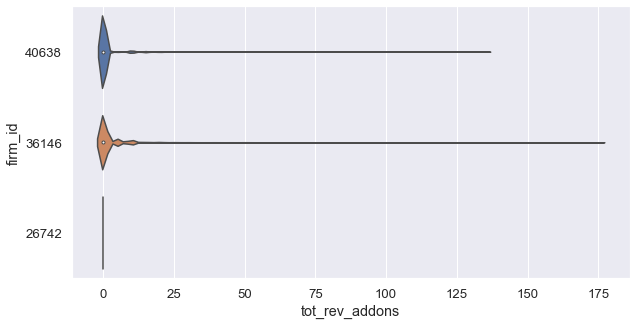

In [16]:
f0 = df.columns.str.contains('firm_id|\d_rev', regex=True)
list_variables = list(df.columns[f0])
df_groupby = df.groupby(['firm_id'])[list_variables].count()
df_groupby.rename(columns={'firm_id': 'firm_id_count'}, inplace=True)
list_variables.remove('firm_id')
print(df_groupby.sort_values(by='firm_id_count', ascending=False)[list_variables])

plt.figure(figsize=(10,5))
_ = sns.violinplot(x='tot_rev_addons', y='firm_id', data=df, 
                   order=[40638,36146,26742], orient='h')

Let's take a look at 'fee' and 'tot_rev'. There is some rare extreme values. In the case of 'tot_rev', those outliers may have a reasonable explanation (e.g., booking for many individuals or the inclusion of many addons). In the case of 'fee', they seem to be mistakes and perhaps they should be excluded. A possible exclusion rule is to ditch rows with fees above the value of the 3rd quartile (i.e., the 75th percentile). That would eliminate less than 4% of the entries for each 'firm_id' (less than 2.5% of all entries for fee in total).

In [17]:
indexes_fee_above_threshold = []
for i in [40638,36146,26742]:
    f0 = df['firm_id'] == i
    threshold = df[f0]['fee'].quantile(0.75)
    f1 = df['fee'] > threshold
    s0 = len(df[f0 & f1])
    s1 = s0/len(df[f0]['fee'])
    for j in df[f0 & f1].index:
        indexes_fee_above_threshold.append(j)
    print('firm_id', i)
    print(df[f0][['fee', 'tot_rev']].describe())
    print(s0, 'entries for fee above the 75th percentile.')
    print(f'{s1:.2%}', 'of the entries for fee above the 75th percentile.')
    print()
ts0 = len(indexes_fee_above_threshold)
ts1 = ts0/len(df['fee'])
print('In total')   
print(ts0, 'entries for fee above the 75th percentile.')
print(f'{ts1:.2%}', 'of the entries for fee above the 75th percentile.')

firm_id 40638
               fee      tot_rev
count  9005.000000  9005.000000
mean     23.583554    57.952027
std      48.003607    75.440967
min       0.000000     0.000000
25%       8.000000    20.000000
50%      10.000000    35.000000
75%      35.000000    70.000000
max     350.000000  2100.000000
341 entries for fee above the 75th percentile.
3.79% of the entries for fee above the 75th percentile.

firm_id 36146
               fee      tot_rev
count  8043.000000  8043.000000
mean     24.150111    72.176302
std      15.921995   109.017858
min       0.000000     0.000000
25%      25.000000    40.000000
50%      25.000000    50.000000
75%      25.000000    75.000000
max    1200.000000  3600.000000
60 entries for fee above the 75th percentile.
0.75% of the entries for fee above the 75th percentile.

firm_id 26742
               fee      tot_rev
count  7983.000000  7983.000000
mean     11.383569    33.939622
std      29.092336    93.538286
min       0.000000     0.000000
25%      10.000

With regard to the columns 'status_cancel' and 'payment_cc', the data available for them practically doesn't vary and, as a result, they will not be consider in further analysis. We will keep the columns 'source_online' and 'discount', although their data doesn't vary that much either. The column 'guests' is certainly more interesting in terms of data variation. The mean values of 'guests' for each firm don't come from the same distribution, but they are close to each other. Firms 26742 and 36146 have mean values of 'guests' between 2 and 3 (they may actually have the same mean value), while firm 40638 has mean value of 'guests' above 3, but probably not above 3.5.

                      status_cancel
                              count
firm_id status_cancel              
26742.0 0.0                    7983
36146.0 0.0                    8043
40638.0 0.0                    9005
{'0': 'confirmed', '1': 'cancelled'}

                   payment_cc
                        count
firm_id payment_cc           
26742.0  1.0             7983
36146.0  1.0             8043
40638.0 -1.0                1
         1.0             9004
{'0': 'cash', '1': 'credit card', '-1': 'none'}

                      source_online
                              count
firm_id source_online              
26742.0 0.0                     194
        1.0                    7789
36146.0 0.0                      27
        1.0                    8016
40638.0 0.0                     484
        1.0                    8521
{'0': 'added', '1': 'online'}

                 discount
                    count
firm_id discount         
26742.0 0.0          7911
        1.0            72
36

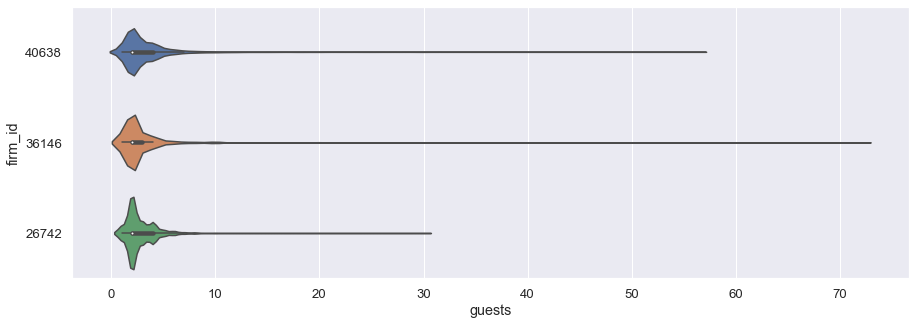

First comparison of means.
H0: difference in means of 'guests' for different 'firm_id' is by chance.
The meaning of H0 is that the means actually come from the same distribution.
Category: firm_id
p-value for H0 in the case of 26742.0 vs. 36146.0 is 0.01
H0 is rejected.
p-value for H0 in the case of 26742.0 vs. 40638.0 is 0.0
H0 is rejected.
p-value for H0 in the case of 36146.0 vs. 40638.0 is 0.0
H0 is rejected.

Second comparison of means.
H0: there is no difference in means of 'guests' for different 'firm_id'.
95% c. i. if 26742.0 = [2.84842791 2.94137542]
95% c. i. if 36146.0 = [2.74250901 2.86622218]
95% c. i. if 40638.0 = [3.34491671 3.49128262]


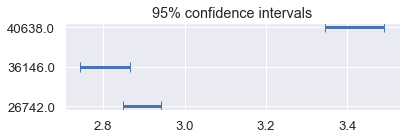

In [18]:
## Counting entries in some columns.
list_variables = ['status_cancel', 'payment_cc', 'source_online', 'discount']

for i in list_variables:
    print(df.groupby(['firm_id', i]).agg({i:['count']}))
    print(df_dic_pub[i])
    print()

## Plotting and analyzing column 'guests'.
plt.figure(figsize=(15,5))
_ = sns.violinplot(x='guests', y='firm_id', data=df, 
                   order=[40638,36146,26742], orient='h')
plt.show()

df_guests = df[['firm_id','guests']].dropna()
df_guests.sort_values(by=['firm_id'], ascending=False, inplace=True)

## First comparison of means.
np.random.seed(10)
print("First comparison of means.")
print("H0: difference in means of 'guests' for different 'firm_id' is by chance.")
print("The meaning of H0 is that the means actually come from the same distribution.")

categories = ['firm_id']
for i in categories:
    print('Category:',i)
    names = np.unique(df_guests[i])
    comb = list(combinations(names, 2))
    for j in comb:
        data_1 = df_guests['guests'][df_guests[i]==j[0]]
        data_2 = df_guests['guests'][df_guests[i]==j[1]]
        empirical_diff_means = diff_of_means(data_1, data_2)
        perm_replicates = draw_perm_reps(data_1, data_2, diff_of_means, size=1000)
        if empirical_diff_means >= 0:
            p = np.sum(perm_replicates >= empirical_diff_means)/len(perm_replicates)
        else:
            p = np.sum(perm_replicates <= empirical_diff_means)/len(perm_replicates)
        print('p-value for H0 in the case of',j[0],'vs.',j[1],'is',p)
        if p > 0.025:
            print('H0 is not rejected.')
        else:
            print('H0 is rejected.')

## Second comparison of means.
print("\nSecond comparison of means.")
print("H0: there is no difference in means of 'guests' for different 'firm_id'.")            

lst = []
for i in np.unique(df_guests['firm_id']):
    data = df_guests['guests'][df_guests['firm_id']==i]
    ci_mean = bs_95_ci(data, np.mean, size=10000)
    lst.append([i, ci_mean[0], ci_mean[1]])
    print('95% c. i. if',i,'=',ci_mean)
df0 = pd.DataFrame(lst)
df0.columns = ['firm_id','ci_min','ci_max']
df0['ci_mid'] = (df0['ci_min'] + df0['ci_max'])/2
df0['half_size'] = df0['ci_mid'] - df0['ci_min']

plt.figure(figsize=(6,1.6))
_ = plt.errorbar(df0['ci_mid'], df0['firm_id'].astype('str'), xerr=df0['half_size'],
                 ls='', elinewidth=3, capsize=5)
plt.title('95% confidence intervals')
plt.show()

Let's now observe 'contact_date' and 'visit_datetime'. Both variables are datetime type. As a result, we can create the variable 'days_bf_visit' to count the days between the contact day and the visit day. We can also analyze the frequence of visits among the 12 months of a year and the 7 days of a week. All entries for visit day are related to the year 2017. The distribution of 'days_bf_visit' are somewhat similar. More about that later. For firms 36146 and 26742, visits are not spread so unevenly among months, although summer months are noticeably busier. For firm 40638, there is no visits in the five first months. That's because contacts booking visits to firm 40638 also started to show up in the dataset only later, as we are going to see further ahead. Firm 40638 probably became a partner of the booking company only later in 2017. As expected, the volume of visits increases during the end of the week.

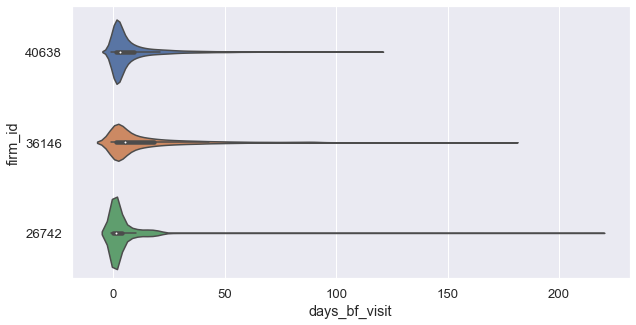

All years for visit are 2017?
True


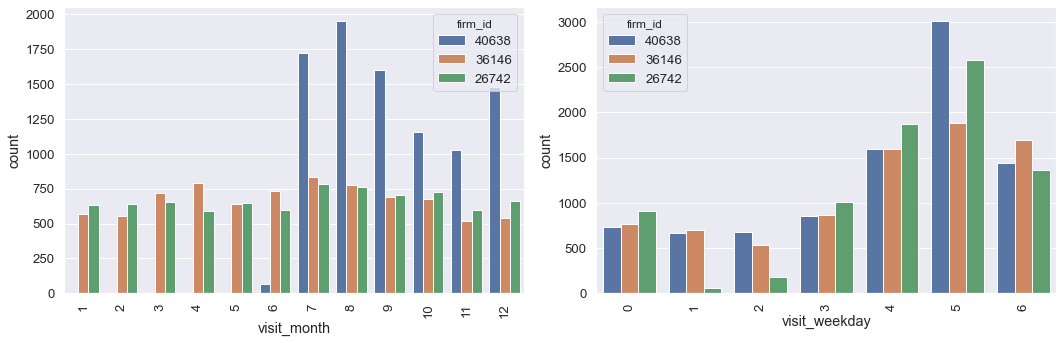

In [19]:
## Create column for year of the contact.
df['contact_year'] = df['contact_date'].dt.year
## Create column for month of the contact, where January=1 and December=12.
df['contact_month'] = df['contact_date'].dt.month
## Create column for day of the contact.
df['contact_day'] = df['contact_date'].dt.day
## Create column for weekday of the contact, where Monday=0 and Sunday=6.
df['contact_weekday'] = df['contact_date'].dt.dayofweek
## Create column for days before visit.
df['days_bf_visit'] = (df['visit_datetime'] - df['contact_date']).dt.days

## Change the position of the new columns in the dataframe.
position = df.columns.get_loc('contact_date')+1
for i in ['contact_year', 'contact_month', 'contact_day', 
          'contact_weekday', 'days_bf_visit']:
    col = df.pop(i)
    df.insert(position, col.name, col)
    position += 1

## Create column for year-month of the visit, where January=1 and December=12.
#df['visit_year_month'] = df['visit_datetime'].dt.to_period('M')
## Create column for year of the visit.
df['visit_year'] = df['visit_datetime'].dt.year
## Create column for month of the visit, where January=1 and December=12.
df['visit_month'] = df['visit_datetime'].dt.month
## Create column for day of the visit.
df['visit_day'] = df['visit_datetime'].dt.day
## Create column for weekday of the visit, where Monday=0 and Sunday=6.
df['visit_weekday'] = df['visit_datetime'].dt.dayofweek
## Create column for hour of the visit.
df['visit_hour'] = df['visit_datetime'].dt.hour

## Change the position of the new columns in the dataframe.
position = df.columns.get_loc('visit_datetime')+1
for i in ['visit_year', 'visit_month', 'visit_day', 
          'visit_weekday', 'visit_hour']:
    col = df.pop(i)
    df.insert(position, col.name, col)
    position += 1

plt.figure(figsize=(10,5))
_ = sns.violinplot(x='days_bf_visit', y='firm_id', data=df, 
                   order=[40638,36146,26742], orient='h')
plt.show()

print('All years for visit are 2017?')
print(all(df['visit_year'] == 2017))
#print(all(df['visit_year_month'].dt.year == 2017))

sns.set(font_scale=1.2)
fig, ax = plt.subplots(1, 2, figsize=(15,5))

_ = sns.countplot(x='visit_month', hue='firm_id', data=df,
                  hue_order=[40638,36146,26742], ax=ax[0])
ax[0].tick_params('x', labelrotation=90)

_ = sns.countplot(x='visit_weekday', hue='firm_id', data=df,
                  hue_order=[40638,36146,26742], ax=ax[1])
ax[1].tick_params('x', labelrotation=90)

plt.tight_layout()
plt.show()

Despite some visual similarity between the distributions of 'days_bf_visit' for each firm, the statistical tests below show that 1-) the means for each firm don't come from the same distribution, and 2-) the means are different from each other. The mean number of days from contact to visit for firm 40638 is probably between 7 and 8, for firm 36146 is about 13, and for firm 26742 is about 4.

First comparison of means.
H0: difference in means of 'days_bf_visit' for different 'firm_id' is by chance.
The meaning of H0 is that the means actually come from the same distribution.
Category: firm_id
p-value for H0 in the case of 26742.0 vs. 36146.0 is 0.0
H0 is rejected.
p-value for H0 in the case of 26742.0 vs. 40638.0 is 0.0
H0 is rejected.
p-value for H0 in the case of 36146.0 vs. 40638.0 is 0.0
H0 is rejected.

Second comparison of means.
H0: there is no difference in means of 'days_bf_visit' for different 'firm_id'.
95% c. i. if 26742.0 = [4.3433515  4.90367343]
95% c. i. if 36146.0 = [13.14333893 13.98048303]
95% c. i. if 40638.0 = [7.75346197 8.25930594]


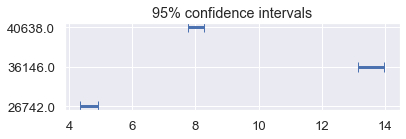

In [20]:
df_days = df[['firm_id','days_bf_visit']].dropna()
df_days.sort_values(by=['firm_id'], ascending=False, inplace=True)

## First comparison of means.
np.random.seed(10)
print("First comparison of means.")
print("H0: difference in means of 'days_bf_visit' for different 'firm_id' is by chance.")
print("The meaning of H0 is that the means actually come from the same distribution.")

categories = ['firm_id']
for i in categories:
    print('Category:',i)
    names = np.unique(df_days[i])
    comb = list(combinations(names, 2))
    for j in comb:
        data_1 = df_days['days_bf_visit'][df_days[i]==j[0]]
        data_2 = df_days['days_bf_visit'][df_days[i]==j[1]]
        empirical_diff_means = diff_of_means(data_1, data_2)
        perm_replicates = draw_perm_reps(data_1, data_2, diff_of_means, size=1000)
        if empirical_diff_means >= 0:
            p = np.sum(perm_replicates >= empirical_diff_means)/len(perm_replicates)
        else:
            p = np.sum(perm_replicates <= empirical_diff_means)/len(perm_replicates)
        print('p-value for H0 in the case of',j[0],'vs.',j[1],'is',p)
        if p > 0.025:
            print('H0 is not rejected.')
        else:
            print('H0 is rejected.')

## Second comparison of means.
print("\nSecond comparison of means.")
print("H0: there is no difference in means of 'days_bf_visit' for different 'firm_id'.")            

lst = []
for i in np.unique(df_days['firm_id']):
    data = df_days['days_bf_visit'][df_days['firm_id']==i]
    ci_mean = bs_95_ci(data, np.mean, size=10000)
    lst.append([i, ci_mean[0], ci_mean[1]])
    print('95% c. i. if',i,'=',ci_mean)
df0 = pd.DataFrame(lst)
df0.columns = ['firm_id','ci_min','ci_max']
df0['ci_mid'] = (df0['ci_min'] + df0['ci_max'])/2
df0['half_size'] = df0['ci_mid'] - df0['ci_min']
plt.figure(figsize=(6,1.6))
_ = plt.errorbar(df0['ci_mid'], df0['firm_id'].astype('str'), xerr=df0['half_size'],
                 ls='', elinewidth=3, capsize=5)
plt.title('95% confidence intervals')
plt.show()

It is possible to use network analysis to see how different firms attract different clients from different regions (US states or foreign countries). The directed network below shows regions in blue connecting to firms in red. It uses booking data from 2016-08-31 to 2017-12-31 ('contact_date'). The size of each node is proportional to its degree (number of edges connecting it). The number on each edge informs its weight in terms of number of connections that edge actually represents. Technically speaking, we have a Weighted DiGraph representing a MultiDiGraph. Higher weights at the edges pull the regions closer to the firms as if firms more connected to a certain region exert more gravitational force on that region. It is a nice way to visualize competing firms in a market, although a more complete description would require the inclusion of all competing firms in that market, not just the three we are analysing. The resulting layout shows that locality is an important attractiveness factor. Firm 40638 from MO attracts a comparatively larger number of clients from MO. Between the three firms, 40638 appears to have the greatest appeal among American clients from different states. On the other hand, firm 36146 appears to have the greatest appeal among foreigner clients. Being from CA, 36146 also attracts a comparatively larger number of clients from that state. Finally, firm 26742 has the greatest appeal among clients in its home state CO.

Weight of edges in D equal to length of those edges in M?
True

         firm_type             firm_loc
firm_id                                
40638          1.0    US_MO_Saint Louis
36146          1.0  US_CA_San Francisco
26742          2.0        US_CO_Denver,


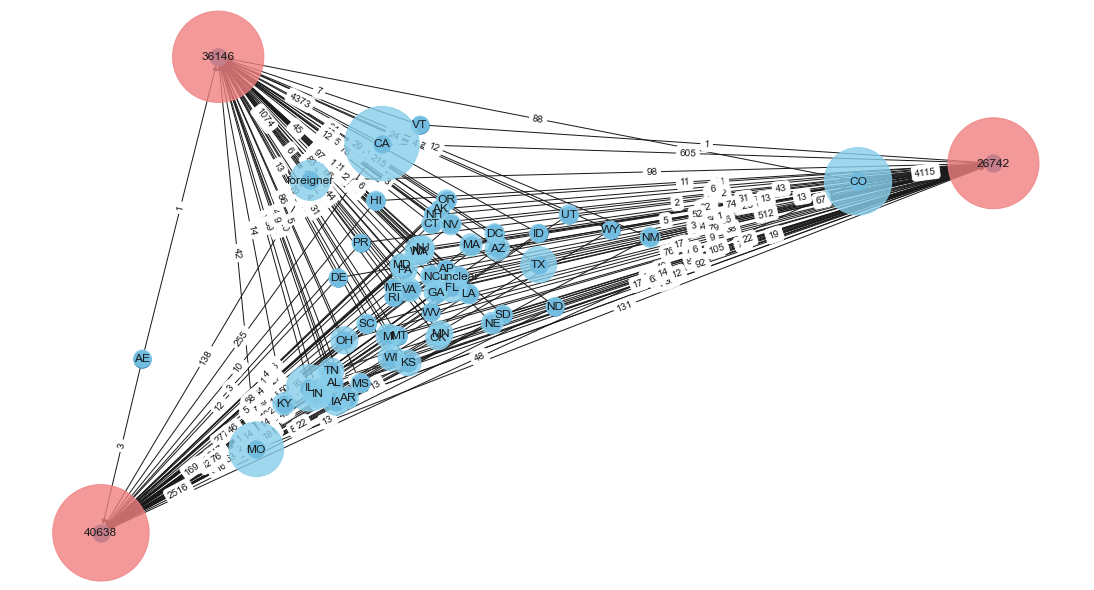

In [21]:
import networkx as nx
#import nxviz as nv

list_variables = ['us_region', 'us_zipcode', 
                  'firm_id', 'firm_type', 'firm_loc', 
                  'contact_date', 'visit_datetime']
df_net = df[list_variables].copy()
df_net['firm_id'] = df_net['firm_id'].astype('int')

## Create MultiDiGraph M.
M = nx.MultiDiGraph()

## Add nodes from each of the partitions.
M.add_nodes_from(df_net['us_region'], bipartite='region')
M.add_nodes_from(df_net['firm_id'], bipartite='firm')

## Add edges along with additional data.
for row, data in df_net.iterrows():
    M.add_edge(data['us_region'], data['firm_id'], 
               contact=data['contact_date'], visit=data['visit_datetime'])

## Create weighted DiGraph D from MultiDiGraph M.
D = nx.DiGraph()

for u,v,data in M.edges(data=True):
    w = data['weight'] if 'weight' in data else 1
    if D.has_edge(u,v):
        D[u][v]['weight'] += w
    else:
        D.add_edge(u, v, weight=w)   

for n in D.nodes:
    D.nodes[n]['bipartite'] = M.nodes[n]['bipartite']     

test_result = []
for u, v in D.edges:
    test = D[u][v]['weight']==len(M[u][v])
    test_result.append(test)
print('Weight of edges in D equal to length of those edges in M?')
print(all(test_result)), print()

#print(D.nodes(data=True)), print()
#print(D.edges(data=True)), print()

## Information about firms.
df_net_groupby = df_net.groupby(['firm_id'])[['firm_type', 'firm_loc']].agg(pd.Series.mode)
print(df_net_groupby.sort_index(ascending=False))

## Draw the weighted DiGraph D.
pos = nx.fruchterman_reingold_layout(D)
edge_labels = nx.get_edge_attributes(D,'weight')    
nodelist = []
node_size = []
node_color = []
node_attributes = nx.get_node_attributes(M, 'bipartite')
for v in node_attributes:
    nodelist.append(v)
    node_size.append(300 + M.degree(v))
    if node_attributes[v] == 'firm':
        node_color.append('lightcoral')
    else:
        node_color.append('skyblue')
        
plt.figure(figsize=(15,8))
nx.draw(D, pos=pos, with_labels=True)
nx.draw_networkx_nodes(D, pos=pos,
                       nodelist=nodelist,
                       node_size=node_size,
                       node_color=node_color,
                       alpha=0.8)
nx.draw_networkx_edge_labels(D, pos=pos, 
                             edge_labels=edge_labels)
plt.show()

The stacked barplot below is another way to show the number of contacts by region and firm. All the information was extracted from the network above. It basically confirms the observations made before: most visitors to a firm are from the firm's home state, firm 40638 has the greatest appeal among American clients from different states (the blue color is overall more present among the bars) and firm 36146 has the greatest appeal among foreigner clients. We also present histograms for degree centrality values of unipartite unweighted projections of our bipartite network above. One histogram is for region nodes and the other is for firm nodes. Because of the nature of our network and the large period of time represented, those histograms don't inform much. Given enough time, every region will develop connections to enough firms so as to be extended connected to each other in their projected network, and every firm will be connected to enough regions so as to be extended connected to each other in their projected network. That explain why the histograms have only one bar at degree centrality 1.

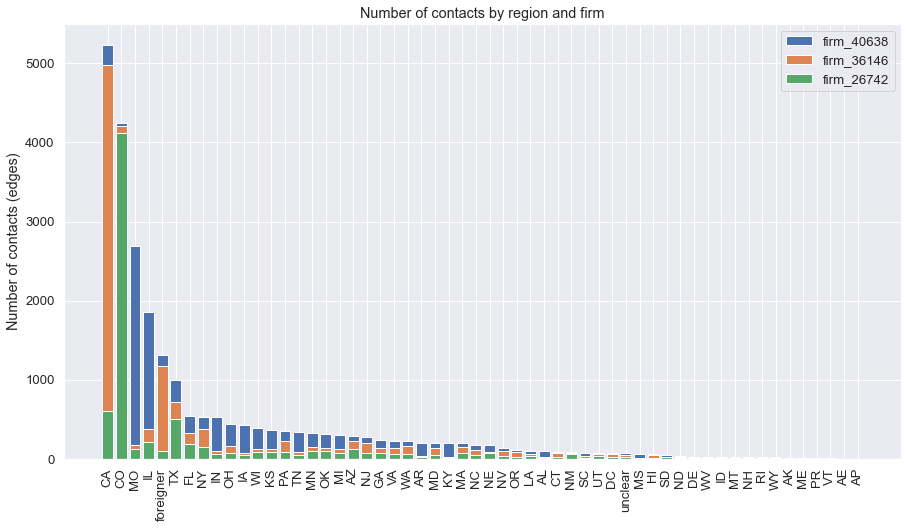

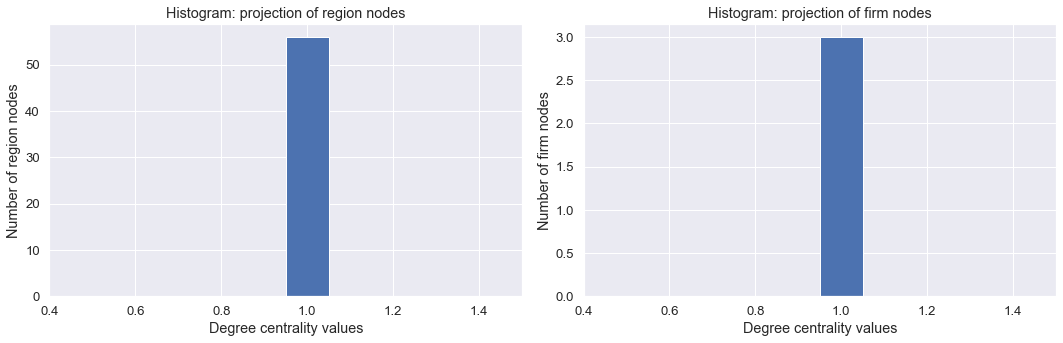

In [22]:
### Stacked barplot to show number of contacts by region and firm.

## Get contacts from edges' weights.
contacts = []
for u, v, d in D.edges(data=True):
    contacts.append((u, v, d['weight']))

## Make dataframe from contacts and pivot it.
df_contacts = pd.DataFrame(contacts, columns =['region', 'firm', 'n_contacts'])
dfp_contacts = df_contacts.pivot(index='region', columns='firm', values='n_contacts')

## Fix columns' names.
columns_name = dfp_contacts.columns.name
dfp_contacts.columns = [columns_name+'_'+str(col) for col in dfp_contacts.columns]

## Change Nan for zero, reset index, create total number of contacts and sort data. 
dfp_contacts.fillna(0, inplace=True)
dfp_contacts.reset_index(inplace=True)
dfp_contacts['total'] =  dfp_contacts['firm_26742']\
                        +dfp_contacts['firm_36146']\
                        +dfp_contacts['firm_40638']
dfp_contacts.sort_values(by=['total'], ascending=False, inplace=True)

## Make plot from dataframe's columns.
contacts_region = dfp_contacts['region']
contacts_40638 = dfp_contacts['firm_40638']
contacts_36146 = dfp_contacts['firm_36146']
contacts_26742 = dfp_contacts['firm_26742']

fig, ax = plt.subplots(figsize=(15,8))
ax.bar(contacts_region, contacts_40638, bottom=contacts_26742+contacts_36146, label='firm_40638')
ax.bar(contacts_region, contacts_36146, bottom=contacts_26742, label='firm_36146')
ax.bar(contacts_region, contacts_26742, label='firm_26742')
ax.set_ylabel('Number of contacts (edges)')
ax.set_title('Number of contacts by region and firm')
ax.tick_params('x', labelrotation=90)
ax.legend()
plt.show()

### Projection onto region nodes and firm nodes.

## Transform weighted DiGraph D into weighted Graph G.
G = nx.Graph(D)

## Get region and firm nodes from G.
region_nodes = [n for n, data in G.nodes(data=True) if data['bipartite'] == 'region']
firm_nodes = [n for n, data in G.nodes(data=True) if data['bipartite'] == 'firm']

## Create projection of G onto region nodes and firm nodes. 
G_region = nx.bipartite.projected_graph(G, nodes=region_nodes)
G_firm = nx.bipartite.projected_graph(G, nodes=firm_nodes)

## Calculate degree centrality values of nodes in G_region and G_firm.
dcs_region = nx.degree_centrality(G_region)
dcs_firm = nx.degree_centrality(G_firm)

# Plot the histogram of degree centrality values.
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].hist(list(dcs_region.values()), align='left')
ax[0].set_title('Histogram: projection of region nodes')
ax[0].set_xlabel('Degree centrality values')
ax[0].set_ylabel('Number of region nodes')

ax[1].hist(list(dcs_firm.values()), align='left')
ax[1].set_title('Histogram: projection of firm nodes')
ax[1].set_xlabel('Degree centrality values')
ax[1].set_ylabel('Number of firm nodes')

plt.tight_layout()
plt.show()

Next, the first graph below shows the number of contacts being made as the time pass in weeks. The contacts come from the column 'contact_date' in our dataframe. They are clients entering in contact with the booking company to schedule visits to firms. The start date is Monday 2016-09-05 and the end date is Sunday 2017-12-24. This graph clarifies why firm 40638 had no visits in the first five months of 2017, as we saw before. Up to 40 weeks from the start date, there was no contacts scheduling visits for that firm. As we said earlier, firm 40638 probably became a partner of the booking company only later in 2017. However, once the contacts started for that firm, the volume was high. The other two firms present a similar evolution of contacts along time in relation to each other, depite being of different types (36146 is type 1.0 whereas 26742 is type 2.0).

The second graph shows the projected degree centrality values of region nodes per week. In a short period of time like a week, it is much more likely that the network formed will contain region nodes with projected degree centrality value lower than 1. The motivation behind the second graph is to see if we can build a meaningful numerical scale to represent the categorical variable 'us_region' based on connectivity. By meaningful we mean a numerical scale where distances between points actually mean something. A meaningful numerical scale would avoid the use of many dummies to represent regions and would incorporate information about the connections among them that could be used in other quantitative analyses. The third graph is derived from the second and shows for each region the 95% confidence interval (95% c. i.) for the mean of the weekly projected degree centrality values. Given a long period of weeks, it is possible to observe which regions are statistically similar or distinct in terms of projected conectivity among them. Most importantly, we now have the regions being represented on a connectivity scale between 0 and 1. We can use the minimum, maximum and middle of these confidence intervals in other quantitative analyses, assuming that those intervals will remain stable as time (weeks) continous to pass. We have added that information to our dataframe under the columns 'region_dc_95min' (minimum value of the 95% c. i.), 'region_dc_95max' (maximum value of the 95% c. i.), 'region_dc_mean' (middle value of the 95% c. i., which is the mean of the weekly projected degree centrality values) and 'region_dc_half_size' (half the size of the 95% c. i.).

Start day (first contact day) is 2016-09-05 , which is the 0 day of the week.
End day (last contact day) is 2017-12-24 , which is the 6 day of the week.


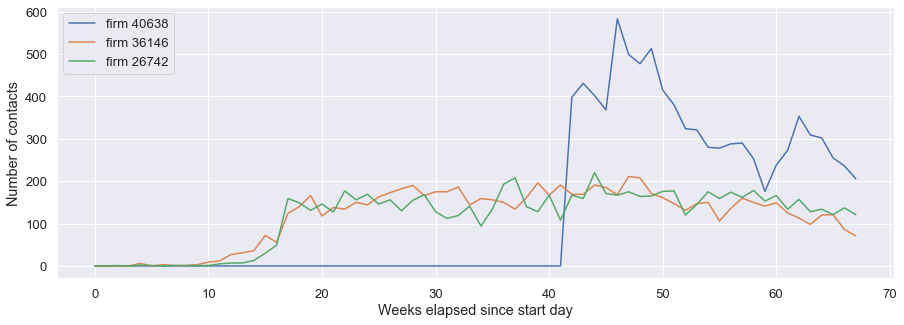

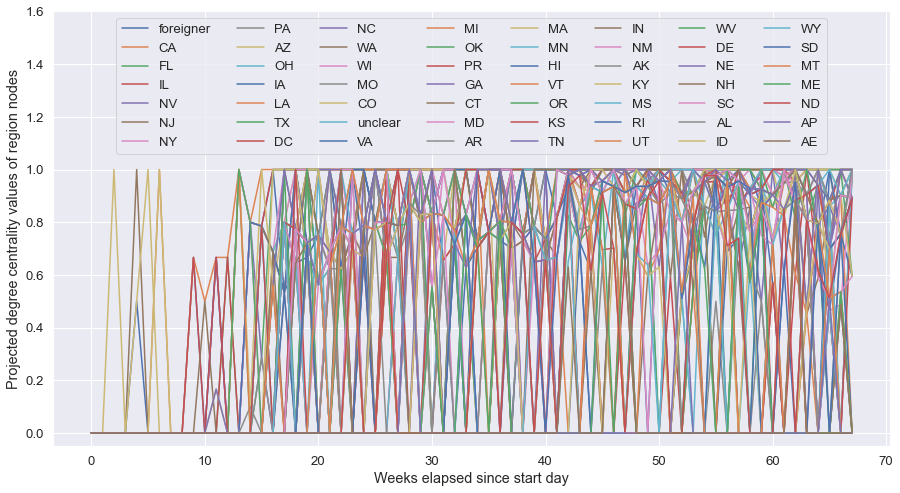

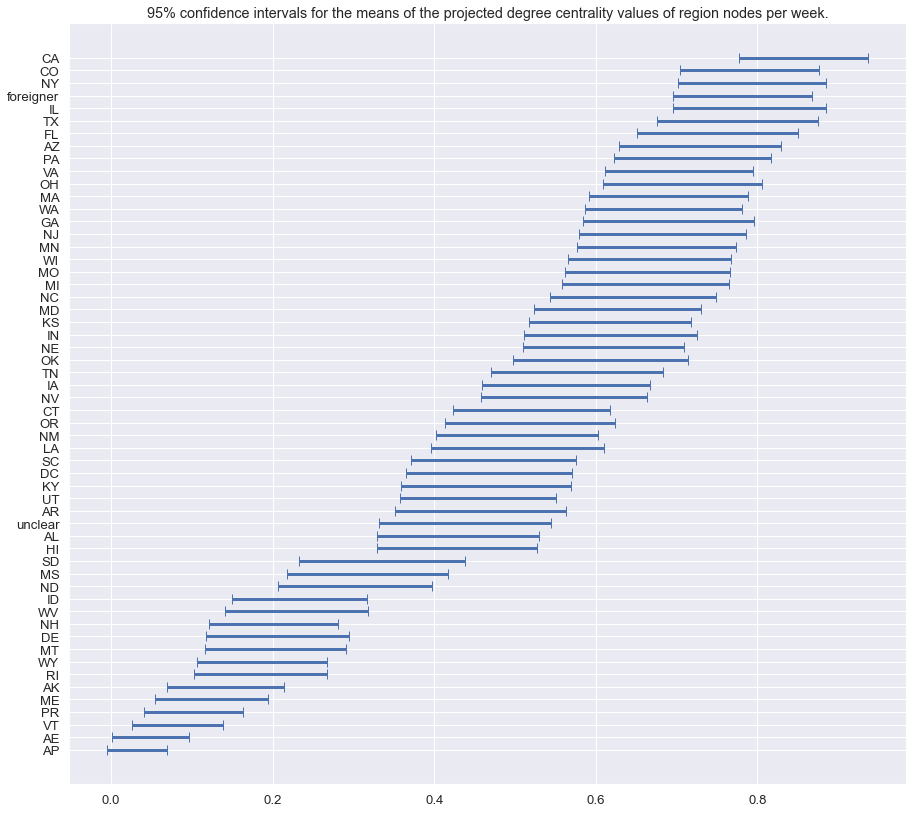

In [23]:
## Define start day, end day and timedelta of 7 days (a week).
day_start = df['contact_date'].min()+timedelta(5)
day_end = df['contact_date'].max()-timedelta(6)
print('Start day (first contact day) is', day_start.date(), 
      ', which is the', day_start.dayofweek, 'day of the week.')
print('End day (last contact day) is', day_end.date(), 
      ', which is the', day_end.dayofweek, 'day of the week.')
curr_day = day_start
td = timedelta(7)

## Create network MultiDiGraph for the week.
M_week = nx.MultiDiGraph()

## Create empty lists for number of contacts, one list for each firm.
n_contacts_firm_40638 = []
n_contacts_firm_36146 = []
n_contacts_firm_26742 = []
## Create empty list for degree centrality values of region nodes.
degree_centralities = []

while curr_day < day_end:
    #if curr_day.day == 1:
        #print(curr_day) 
    ## Filter edges such that they are within the sliding time window.
    edges_40638 = [(u, v, d) for u, v, d in M.edges(data=True) if v == 40638 and 
                   d['contact'] >= curr_day and d['contact'] < curr_day + td]
    edges_36146 = [(u, v, d) for u, v, d in M.edges(data=True) if v == 36146 and 
                   d['contact'] >= curr_day and d['contact'] < curr_day + td]
    edges_26742 = [(u, v, d) for u, v, d in M.edges(data=True) if v == 26742 and 
                   d['contact'] >= curr_day and d['contact'] < curr_day + td]
    ## Add edges to draw the network M_week for the week.
    M_week.add_edges_from([(u, v, d) for u, v, d in M.edges(data=True) if 
                           d['contact'] >= curr_day and d['contact'] < curr_day + td])
    ## Add bipartite information to the nodes of M_week.
    for n in M_week.nodes:
        M_week.nodes[n]['bipartite'] = M.nodes[n]['bipartite']
    ## Transform M_week into Graph G_week and create projection onto region nodes.
    G_week = nx.Graph(M_week)
    region_nodes = [n for n, d in G_week.nodes(data=True) if d['bipartite'] == 'region']
    G_week_region = nx.bipartite.projected_graph(G_week, nodes=region_nodes)
    ## Calculate degree centrality values of region nodes in G_Week_region.
    week_dcs_region = nx.degree_centrality(G_week_region)
    
    ## Append number of edges to the respective lists.
    n_contacts_firm_40638.append(len(edges_40638))
    n_contacts_firm_36146.append(len(edges_36146))
    n_contacts_firm_26742.append(len(edges_26742))
    ## Append degree centrality values to the respective list.
    degree_centralities.append(week_dcs_region)
    
    ## Clear networks and increment the curr_day by the timedelta.
    M_week.clear()
    G_week.clear()
    G_week_region.clear()
    curr_day += td
    
## Create the plot for number of contacts.
plt.figure(figsize=(15,5))
plt.plot(n_contacts_firm_40638, label='firm 40638')
plt.plot(n_contacts_firm_36146, label='firm 36146')
plt.plot(n_contacts_firm_26742, label='firm 26742')
plt.legend(loc='upper left')
plt.xlabel('Weeks elapsed since start day')
plt.ylabel('Number of contacts')
plt.show()  

## degree_centralities is a list of dictionaries.
## It shows projected degree centrality values of region nodes per week.
## Create defaultdict to centralize information from degree_centralities.
dic_dcs_regions = defaultdict(list)
for i in M.nodes():
    for j in degree_centralities:
        if i not in j.keys():
            dic_dcs_regions[i].append(0)
        else:
            dic_dcs_regions[i].append(j[i])

## Create the plot for projected degree centrality values of region nodes per week.
plt.figure(figsize=(15,8))
list_to_remove = [26742, 36146, 40638]
list_to_include = [i for i in M.nodes() if i not in list_to_remove]
for i in list_to_include:
    plt.plot(dic_dcs_regions[i], label=i)
plt.legend(loc='upper center', ncol=int(len(list_to_include)/7))
plt.xlabel('Weeks elapsed since start day')
plt.ylabel('Projected degree centrality values of region nodes')
plt.ylim(top=1.6) 
plt.show()  

## Create the plot of confidence intervals for the means...
## ...of the projected degree centrality values of region nodes per week.
lst=[]
for i in list_to_include:
    ci_min = sms.DescrStatsW(dic_dcs_regions[i]).tconfint_mean()[0]
    ci_max = sms.DescrStatsW(dic_dcs_regions[i]).tconfint_mean()[1]
    lst.append((i, ci_min, ci_max))
lst.sort(key=lambda x:x[1])
df0 = pd.DataFrame(lst)
df0.columns = ['us_region','region_dc_95min','region_dc_95max']
df0['region_dc_mean'] = (df0['region_dc_95min'] + df0['region_dc_95max'])/2
df0['region_dc_half_size'] = df0['region_dc_mean'] - df0['region_dc_95min']
plt.figure(figsize=(15,14))
_ = plt.errorbar(df0['region_dc_mean'], df0['us_region'], 
                 xerr=df0['region_dc_half_size'], ls='', elinewidth=3, capsize=5)
plt.title('95% confidence intervals for the means of the projected \
degree centrality values of region nodes per week.')
plt.show()

## Add that information to the dataframe for perhaps future use.
position = df.columns.get_loc('us_region')+1
for i in df0.columns:
    if i != 'us_region':
        df[i] = df['us_region'].map(df0.set_index('us_region')[i])
        col = df.pop(i)
        df.insert(position, col.name, col)
        position += 1

As we noticed earlier, summer months are noticeably busier. So let's take a quick look in the network during the month of July. Below we can see the weighted directed network filtered for date of visit. We only added entries with date of visit between 2017-07-01 and 2017-07-31. The conclusions are basically the same.

Weight of edges in D_sub equal to length of those edges in M_sub?
True

         firm_type             firm_loc
firm_id                                
40638          1.0    US_MO_Saint Louis
36146          1.0  US_CA_San Francisco
26742          2.0        US_CO_Denver,


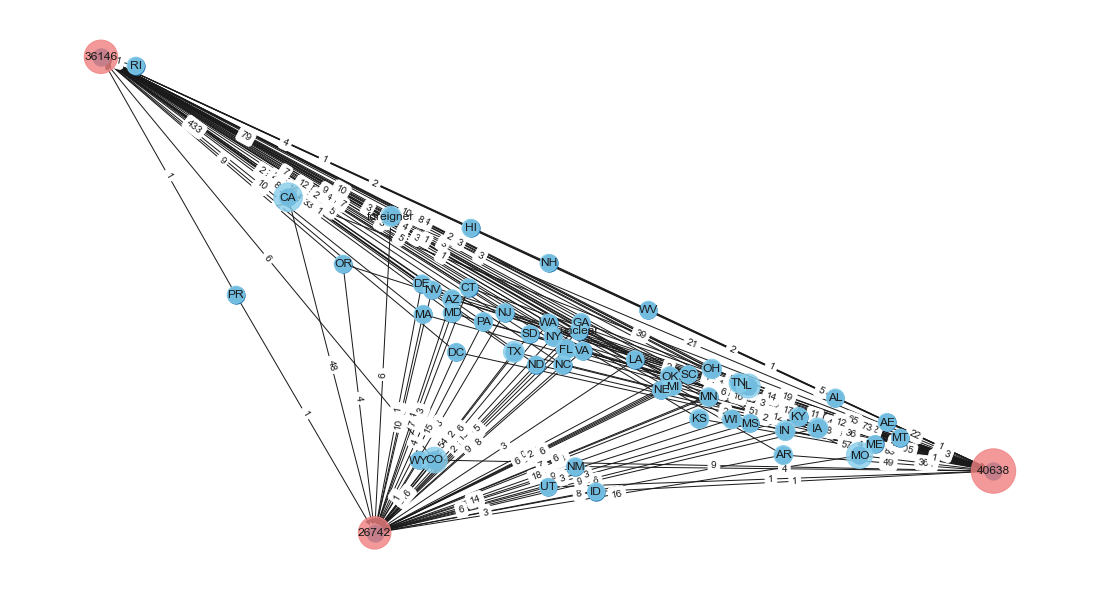

In [24]:
## Create filtered MultiDigraph M_sub.
M_sub = nx.MultiDiGraph()

## Add nodes from the original MultiDiGraph M.
M_sub.add_nodes_from(M.nodes(data=True))

## Add edges using a list comprehension with conditional on the edge dates.
M_sub.add_edges_from([(u, v, data) for u, v, data in M.edges(data=True) 
                      if data['visit'] >= datetime(2017, 7, 1) 
                      and data['visit'] <= datetime(2017, 7, 31)])

## Remove isolate nodes.
dcs = nx.degree_centrality(M_sub)
isolate_nodes = []
for n in M_sub.nodes:
    if dcs[n]==0:
        isolate_nodes.append(n)
M_sub.remove_nodes_from(isolate_nodes)

## Create filtered weighted DiGraph D_sub from M_sub.
D_sub = nx.DiGraph()

for u,v,data in M_sub.edges(data=True):
    w = data['weight'] if 'weight' in data else 1
    if D_sub.has_edge(u,v):
        D_sub[u][v]['weight'] += w
    else:
        D_sub.add_edge(u, v, weight=w)   

for n in D_sub.nodes:
    D_sub.nodes[n]['bipartite'] = M_sub.nodes[n]['bipartite']     

test_result = []
for u, v in D_sub.edges:
    test = D_sub[u][v]['weight']==len(M_sub[u][v])
    test_result.append(test)
print('Weight of edges in D_sub equal to length of those edges in M_sub?')
print(all(test_result)), print()

#print(D.nodes(data=True)), print()
#print(D.edges(data=True)), print()

## Information about firms.
df_net_groupby = df_net.groupby(['firm_id'])[['firm_type', 'firm_loc']].agg(pd.Series.mode)
print(df_net_groupby.sort_index(ascending=False))

## Draw the filtered weighted DiGraph D_sub.
pos = nx.fruchterman_reingold_layout(D_sub)
edge_labels = nx.get_edge_attributes(D_sub,'weight')    
nodelist = []
node_size = []
node_color = []
node_attributes = nx.get_node_attributes(M_sub, 'bipartite')
for v in node_attributes:
    nodelist.append(v)
    node_size.append(300 + M_sub.degree(v))
    if node_attributes[v] == 'firm':
        node_color.append('lightcoral')
    else:
        node_color.append('skyblue')
        
plt.figure(figsize=(15,8))
nx.draw(D_sub, pos=pos, with_labels=True)
nx.draw_networkx_nodes(D_sub, pos=pos,
                       nodelist=nodelist,
                       node_size=node_size,
                       node_color=node_color,
                       alpha=0.8)
nx.draw_networkx_edge_labels(D_sub, pos=pos, 
                             edge_labels=edge_labels)
plt.show()

We again present the stacked barplot for the number of contacts by region and firm, but now considering only the month of July 2017. Nothing particularly new here. The month of July seems to be a good proxy for what happens during a whole year of visits. A highligth would be the clearer overall dominance of the blue color among the bars, reinforcing the appeal of firm 40638 among American clients from different states (taking into comparison only the three firms we are analysing). As for the histograms for degree centrality values of unipartite unweighted projections, because the period of time is shorter, we can see some variance between region nodes in their projected network, meaning that in July some regions didn't develop connections to enough firms so as to be extended connected to all other regions.

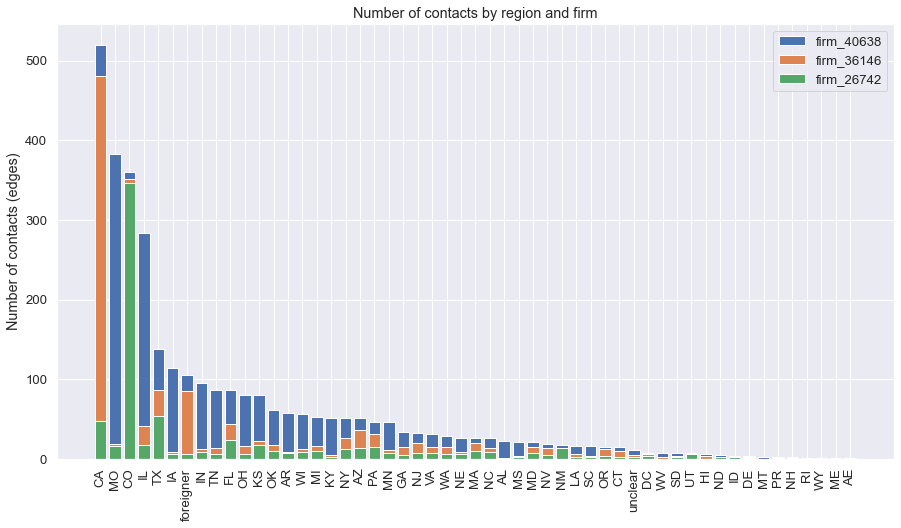

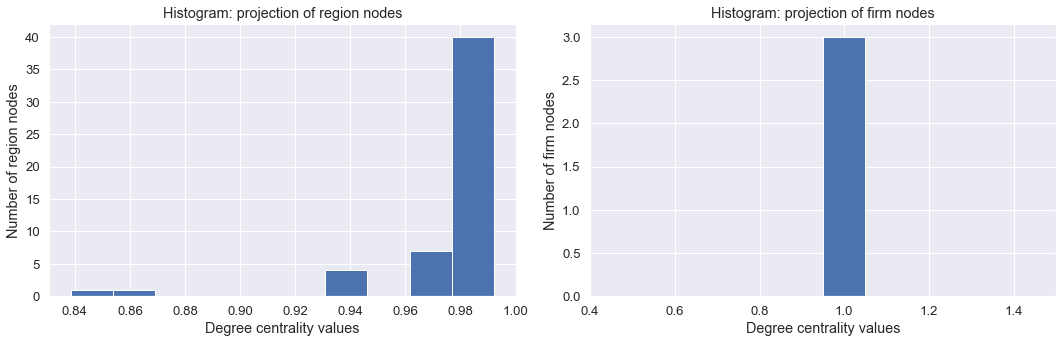

In [25]:
### Stacked barplot to show number of contacts by region and firm.

## Get contacts from edges' weights.
contacts = []
for u, v, d in D_sub.edges(data=True):
    contacts.append((u, v, d['weight']))

## Make dataframe from contacts and pivot it.
df_contacts = pd.DataFrame(contacts, columns =['region', 'firm', 'n_contacts'])
dfp_contacts = df_contacts.pivot(index='region', columns='firm', values='n_contacts')

## Fix columns' names.
columns_name = dfp_contacts.columns.name
dfp_contacts.columns = [columns_name+'_'+str(col) for col in dfp_contacts.columns]

## Change Nan for zero, reset index, create total number of contacts and sort data. 
dfp_contacts.fillna(0, inplace=True)
dfp_contacts.reset_index(inplace=True)
dfp_contacts['total'] =  dfp_contacts['firm_26742']\
                        +dfp_contacts['firm_36146']\
                        +dfp_contacts['firm_40638']
dfp_contacts.sort_values(by=['total'], ascending=False, inplace=True)

## Make plot from dataframe's columns.
contacts_region = dfp_contacts['region']
contacts_40638 = dfp_contacts['firm_40638']
contacts_36146 = dfp_contacts['firm_36146']
contacts_26742 = dfp_contacts['firm_26742']

fig, ax = plt.subplots(figsize=(15,8))
ax.bar(contacts_region, contacts_40638, bottom=contacts_26742+contacts_36146, label='firm_40638')
ax.bar(contacts_region, contacts_36146, bottom=contacts_26742, label='firm_36146')
ax.bar(contacts_region, contacts_26742, label='firm_26742')
ax.set_ylabel('Number of contacts (edges)')
ax.set_title('Number of contacts by region and firm')
ax.tick_params('x', labelrotation=90)
ax.legend()
plt.show()

### Projection onto region nodes and firm nodes.

## Transform filtered weighted DiGraph D_sub into filtered weighted Graph G_sub.
G_sub = nx.Graph(D_sub)

## Get region and firm nodes from G_sub.
region_nodes = [n for n, data in G_sub.nodes(data=True) if data['bipartite'] == 'region']
firm_nodes = [n for n, data in G_sub.nodes(data=True) if data['bipartite'] == 'firm']

## Create projection of G_sub onto region nodes and firm nodes. 
G_region = nx.bipartite.projected_graph(G_sub, nodes=region_nodes)
G_firm = nx.bipartite.projected_graph(G_sub, nodes=firm_nodes)

## Calculate degree centrality values of nodes in G_region and G_firm.
dcs_region = nx.degree_centrality(G_region)
dcs_firm = nx.degree_centrality(G_firm)

# Plot the histogram of degree centrality values.
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].hist(list(dcs_region.values()), align='left')
ax[0].set_title('Histogram: projection of region nodes')
ax[0].set_xlabel('Degree centrality values')
ax[0].set_ylabel('Number of region nodes')

ax[1].hist(list(dcs_firm.values()), align='left')
ax[1].set_title('Histogram: projection of firm nodes')
ax[1].set_xlabel('Degree centrality values')
ax[1].set_ylabel('Number of firm nodes')

plt.tight_layout()
plt.show()

Now that we understand better our dataset, let's trim it a little more and proceed with further analysis:

- Columns 'q3' and 'feedback' will be ditched. Among the columns related to questions and feedback, only 'q1_bef' and 'q2' have a good amount of non-null entries. The column 'q1_aft' will be kept in spite of its high number of null entries because it is an interesting follow-up of column 'q1_bef'.

- Columns related to addons will be ditched. They are specific to each firm. Addons 02, 10, 11 and 24 are specific to firm 40638. Addons 01, 13, 14 and 16 are specific to firm 36146. There is no addons for firm 26742. In each case, the amount of non-null entries is small compared to the size of the sample. On the other hand, the columns 'tot_rev_addons' and 'tot_rev' will be kept, the latter being 'fee' * 'guests' + 'tot_rev_addons'. 

- Column 'tot_quant_addons' will be ditched. It does not make sense to sum quantities of addons from different varieties or qualities.

- The columns 'status_cancel' and 'payment_cc' will be ditched. The data available for them practically doesn't vary. On the other hand, the columns 'source_online' and 'guests' will be kept.

- Rows where column 'fee' have values above the threshold of the 3rd quartile (i.e., the 75th percentile) will be ditched just to play safe. They represent less than 4% of the entries for each 'firm_id' (less than 2.5% of all entries in total).

- Rows where the columns 'q1_bef' and 'q2' are null will be ditched. In regard to 'q1_bef', they represent between 6.79% and 1.79% of the entries depending on the 'firm_id' (4.08% of all entries in total). In regard to 'q2', they represent between 5.39% and 1.79% of the entries depending on the 'firm_id' (3.58% of all entries in total).

In summary, 29 columns and 1421 rows will be lost (regarding the rows, they represent 5.68% of the total rows in the dataframe before the trimming process). Some columns were also removed after the trimming process due to lack of variation. The resulting dataframe contains 29 columns and 23610 entries. It is leaner, easier to read and has no null entries except in 'q1_aft', which is a problem that we will try to overcome later.

In [26]:
columns_to_remove = [col for col in df.columns if 'addon_' in col]+\
                    ['tot_quant_addons']+\
                    ['q3', 'feedback']+\
                    ['status_cancel', 'payment_cc']
                    
indexes_to_remove = list(set(indexes_q1_bef_null+
                             indexes_q2_null+
                             indexes_fee_above_threshold))

try:
    df.drop(columns=columns_to_remove, inplace=True)
    df.drop(index=indexes_to_remove, inplace=True)
    print(len(columns_to_remove), 'columns removed.')
    print(len(indexes_to_remove), 'rows removed.')
    tp = len(indexes_to_remove)/indexes_total
    print(f'{tp:.2%}', 'of the rows were removed.')
    print()
except KeyError:
    print('You have run this cell more than once \
and the trimming process has been completed before.')
    print()

columns_no_variation = []
for i in df.columns:
    if len(set(df[i]))==1:
        columns_no_variation.append(i)

print('Are there columns left with no variation?')
if columns_no_variation == []:
    print('No.')
else:
    print('Yes, the following, which are going to be removed:')
    print(*columns_no_variation, sep=', ')
    df.drop(columns=columns_no_variation, inplace=True)

print()
print(df.info())

29 columns removed.
1421 rows removed.
5.68% of the rows were removed.

Are there columns left with no variation?
Yes, the following, which are going to be removed:
visit_year, source_online

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23610 entries, 132755 to 181698
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   country              23610 non-null  object        
 1   us_region            23610 non-null  object        
 2   region_dc_95min      23610 non-null  float64       
 3   region_dc_95max      23610 non-null  float64       
 4   region_dc_mean       23610 non-null  float64       
 5   region_dc_half_size  23610 non-null  float64       
 6   us_zipcode           23610 non-null  object        
 7   firm_id              23610 non-null  float64       
 8   firm_type            23610 non-null  float64       
 9   firm_loc             23610 non-null  object        
 10  cont

As we can see, 'q1_aft' is the only column with null entries. In fact, it contains 14,851 null entries (about 63% of the entries). However, there is enough non-null entries to allow for "guessing" the null entries by using supervised classification. Basically, we want to predict the target variable 'q1_aft' using a set of attributes from the dataframe df. We can start selecting those attributes by analyzing the linear correlation coefficients between some canditates, and that analysis can take the form of a heatmap, keeping in mind that linear correlation coefficients can go from 1 (perfect positive linear correlation) to 0 (no linear correlation) and then to -1 (perfect negative linear correlation). According to the first heatmap below:

- Many variables don't seem to have strong linear correlation between them, which is good in the sense of avoiding problems with multicollinearity.

- 'region_dc_mean' and 'region_dc_half_size' would have a strong negative linear correlation, but a non-linear correlation would better fit the data and tell a more complete and slightly different story, as illustrated by their scatter plot (see below). It goes to show that linear correlation coefficients must be taken with a "grain of salt". Both variables are important because they report different things: one reports average value while the other reports uncertainty.

- 'firm_id' and 'firm_type' seem to be strongly correlated. In order to avoid problems with multicollinearity, it makes more sense to substitute them for dummies identifying each firm.

- 'contact_month' and 'visit_month' also seem to be strongly correlated. That is probably because there is a certain pattern in the number of days between contact and visit. In order to avoid problems with multicollinearity, it is better to keep just one of them (for example, 'visit_month') together with 'days_bf_visit'.

- 'fee', 'guests', 'tot_rev_addons' and 'tot_rev' show some degree of correlation. That shouldn't be a surprise given that 'tot_rev' is 'fee' * 'guests' + 'tot_rev_addons'. In order to avoid problems with multicollinearity and simplify the analysis, it may be better to create 'tot_rev_fees' = 'fee' * 'guests' and keep it together with 'tot_rev_addons', not including 'tot_rev' as attribute.

After the changes, the result is the second heatmap below. Only three correlations present coefficient around or above 0.5 in absolute value: 'region_dc_mean' vs 'region_dc_half_size', which we have already discussed; 'firm_id_26742' vs 'firm_id_36146', which is understandable (when one dummy is 1, the other is necessarily 0, which results in correlation); and 'q1_bef' vs 'q2', suggesting that people who uses more the product is also more likely to recommend it. Overall, the coefficients are not so high and multicolinearity shouldn't be a problem. The variables in the second heatmap seem to be good candidates to attributes.

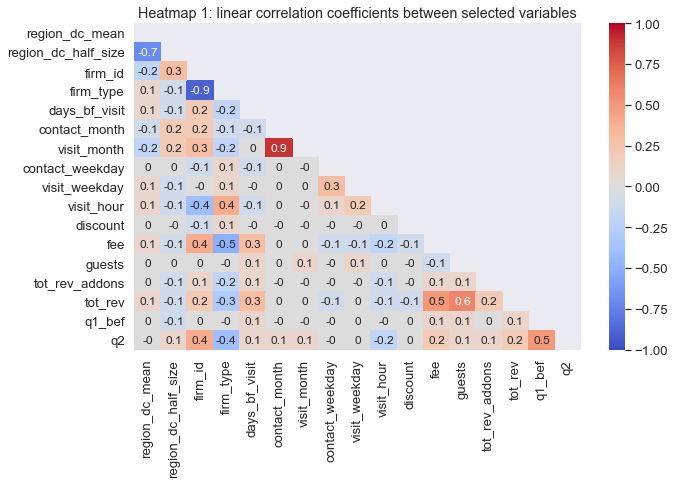

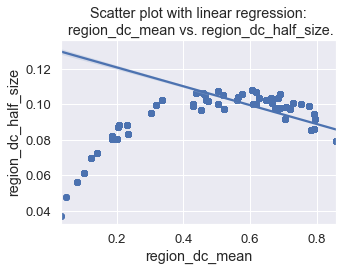

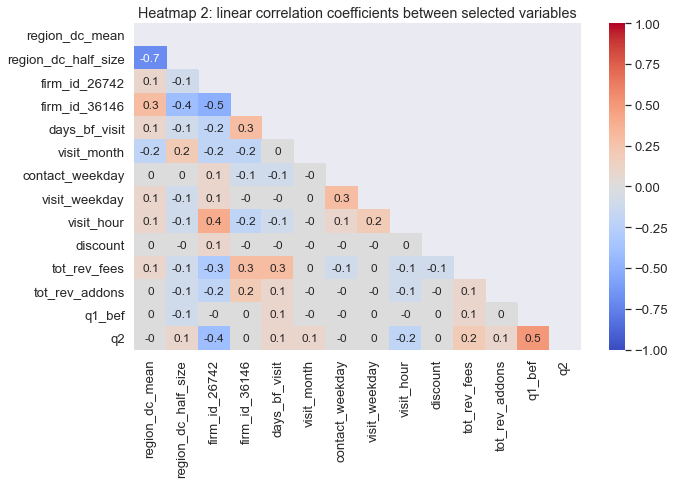

In [27]:
## First list of selected attributes.
list_col = ['region_dc_mean', 'region_dc_half_size', 
            'firm_id', 'firm_type', 
            'days_bf_visit', 'contact_month', 'visit_month', 
            'contact_weekday', 'visit_weekday', 'visit_hour', 
            'discount', 'fee', 'guests', 'tot_rev_addons', 'tot_rev', 
            'q1_bef', 'q2']

## Create dataframe X with attributes from dataframe df.
X = df[list_col].astype(float)
X_corr = X.corr()
mask = np.zeros_like(X_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

## Plot first heatmap with linear correlation coefficients.
fig, ax = plt.subplots(figsize=(10,6))
_ = sns.heatmap(X_corr.round(1), vmin=-1, vmax=1, cmap='coolwarm',
                annot=True, annot_kws={"fontsize":12}, mask = mask)
ax.set_title('Heatmap 1: linear correlation coefficients \
between selected variables')
plt.show()

## Plot region_dc_mean vs. region_dc_half_size.
fig, ax = plt.subplots(figsize=(5,4))
ax = sns.regplot(x='region_dc_mean', y='region_dc_half_size', data=X)
ax.set_title('Scatter plot with linear regression:\
\n region_dc_mean vs. region_dc_half_size.')
plt.tight_layout()
plt.show()

## Create dummies for firm_id and put them in the dataframe df.
dummies = pd.get_dummies(df['firm_id'].astype(int), 
                         prefix='firm_id', dtype=float)
list_dummies = sorted(dummies.columns.to_list())
not_in_df = sorted(list(set(dummies.columns) - set(df.columns)))
if list_dummies == not_in_df:
    df = pd.concat([df, dummies], axis=1)

## Change the position of the dummies in the dataframe df.
position = df.columns.get_loc('firm_id')+1
for i in dummies.columns:
    col = df.pop(i)
    df.insert(position, col.name, col)
    position += 1

## Create 'tot_rev_fees' = 'fee' * 'guests' and change its position in df.
df['tot_rev_fees'] = df['fee'] * df['guests']
position = df.columns.get_loc('discount')+1
col = df.pop('tot_rev_fees')
df.insert(position, col.name, col)

## Second list of selected attributes.
list_col = ['region_dc_mean', 'region_dc_half_size', 
            'firm_id_26742', 'firm_id_36146', 
            'days_bf_visit', 'visit_month', 
            'contact_weekday', 'visit_weekday', 'visit_hour', 
            'discount', 'tot_rev_fees', 'tot_rev_addons', 
            'q1_bef', 'q2']

## Create dataframe X with attributes from dataframe df.
X = df[list_col].astype(float)
X_corr = X.corr()
mask = np.zeros_like(X_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

## Plot second heatmap with linear correlation coefficients.
fig, ax = plt.subplots(figsize=(10,6))
_ = sns.heatmap(X_corr.round(1), vmin=-1, vmax=1, cmap='coolwarm',
                annot=True, annot_kws={"fontsize":12}, mask = mask)
ax.set_title('Heatmap 2: linear correlation coefficients \
between selected variables')
plt.show()

Ideally, we would like to have attributes that are not strongly correlated to each other, but are strongly correlated with the target varible, which in our case would be 'q1_aft'. Unfortunately, when we analyze the linear correlation coefficients between 'q1_aft' and the selected attributes (the ones represented in the second heatmap above), the results are not great (see below): the highest coefficient, the one for 'q1_aft' vs 'q1_bef', is only 0.16 . 

In order to improve that, we decide to use a target variable still connected to 'q1_aft' but expressing a reduced number of categories. The original plan would include 'q1_aft' directly. However, by doing so, we would have to deal with 11 categories: scores from 0 to 10. Instead, we decided to take the difference between 'q1_aft' and 'q1_bef' by making 'q1_dif' = 'q1_aft' - 'q1_bef'. We then created a new variable called 'q1_dif3' which associates the value -1 for 'q1_dif' < 0, 0 for 'q1_dif' = 0, and 1 for 'q1_dif' > 0. In short, the new target variable 'q1_dif3' has only three categories: -1 if the visit had a negative impact on the client, 0 if the visit was neutral, and 1 if the visit had a positive impact on the client. When we analyze the linear correlation coefficients between 'q1_dif3' and the selected attributes, we can see that the highest coefficient is now 0.6 for q1_dif3 vs q1_bef, and the second highest is 0.35 in absolute value for q1_dif3 vs q2. 

It is important to remember that the analysis below is just a first approach that provides some clues but doesn't tell the whole story because linear correlation coefficients don't capture possible non-linear correlations. That's why we don't simply discharge attributes with low linear correlation coefficients.

Linear correlation coefficients in relation to q1_aft
-0.01 between q1_aft and region_dc_mean
-0.01 between q1_aft and region_dc_half_size
+0.05 between q1_aft and firm_id_26742
+0.02 between q1_aft and firm_id_36146
+0.01 between q1_aft and days_bf_visit
-0.08 between q1_aft and visit_month
-0.01 between q1_aft and contact_weekday
-0.04 between q1_aft and visit_weekday
-0.07 between q1_aft and visit_hour
+0.02 between q1_aft and discount
+0.02 between q1_aft and tot_rev_fees
-0.01 between q1_aft and tot_rev_addons
+0.16 between q1_aft and q1_bef
+0.04 between q1_aft and q2

Linear correlation coefficients in relation to q1_dif3
-0.02 between q1_dif3 and region_dc_mean
+0.01 between q1_dif3 and region_dc_half_size
+0.09 between q1_dif3 and firm_id_26742
-0.02 between q1_dif3 and firm_id_36146
-0.07 between q1_dif3 and days_bf_visit
-0.04 between q1_dif3 and visit_month
+0.02 between q1_dif3 and contact_weekday
-0.02 between q1_dif3 and visit_weekday
-0.02 between q1_dif3 and visit_hour

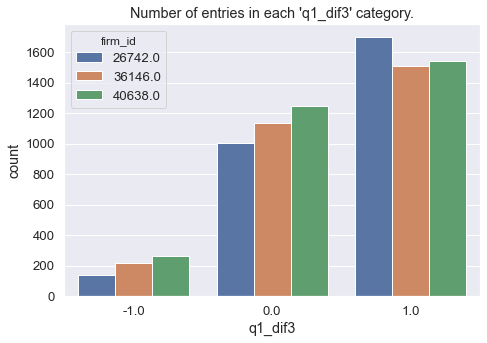

In [28]:
## Print linear correlation coefficients in relation to target q1_aft.
print('\033[1m'+'Linear correlation coefficients \
in relation to q1_aft'+'\033[0m')
y = df.dropna()['q1_aft'].astype(float)
for i in X.columns:
    x = df.dropna()[i].astype(float)
    corr_yx = y.corr(x).round(2)
    print(f'{corr_yx:+.2f}', 'between q1_aft and', i)
print()

## Create 'q1_dif' = 'q1_aft' - 'q1_bef' and change its position in df.
df['q1_dif'] = df['q1_aft'] - df['q1_bef']
position = df.columns.get_loc('q1_aft')+1
col = df.pop('q1_dif')
df.insert(position, col.name, col)

## Create 'q1_dif3' and change its position in df.
q1_dif = df['q1_dif'].astype(float).fillna(99)
list_conditions = [(q1_dif<0), (q1_dif==0), ((q1_dif>0) & (q1_dif<99))]
list_values = [-1, 0, 1]
df['q1_dif3'] = np.select(list_conditions, list_values, default=np.nan)
position = df.columns.get_loc('q1_dif')+1
col = df.pop('q1_dif3')
df.insert(position, col.name, col)

## Print linear correlation coefficients in relation to target q1_dif3.
print('\033[1m'+'Linear correlation coefficients \
in relation to q1_dif3'+'\033[0m')
y = df.dropna()['q1_dif3'].astype(float)
for i in X.columns:
    x = df.dropna()[i].astype(float)
    corr_yx = y.corr(x).round(2)
    print(f'{corr_yx:+.2f}', 'between q1_dif3 and', i)

fig, ax = plt.subplots(figsize=(7,5))
ax = sns.countplot(x='q1_dif3', hue='firm_id', data=df)
ax.set_title("Number of entries in each 'q1_dif3' category.")
plt.tight_layout()
plt.show()

Once defined the target variable as 'q1_dif3' and the list of attributes as the one illustrated in Heatmap 2, we can proceed with the objective of using supervised classification to predict the 14,851 null entries of the target variable. Before starting to implement supervised classification, we will make a quick Principal Component Analysis (PCA) of the attributes to check the potential for dimensionality reduction. The graphs below representing explained variance and cumulative explained variance ratio vis-à-vis PCA features does not show a clear intrinsic dimension for our list of attributes. Four dimensions can explain 51% while nine dimensions can explain 84% of the variance. We will leave the decision regarding dimensionality for the optimization algorithm (coming next).

In [29]:
## Getting the necessary modules (tools).
from sklearn.preprocessing import StandardScaler, MinMaxScaler,\
                                  RobustScaler, Normalizer,\
                                  QuantileTransformer, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split,\
                                    GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet,\
                                 LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix,roc_curve,\
                            roc_auc_score, mean_squared_error,\
                            silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from scipy.stats import norm, t, probplot
import statsmodels.api as sm
from statsmodels.formula.api import ols

Shape of X_train: (6569, 14)
Shape of X_train_transformed: (6569, 14)
Shape of X_train_transformed_alt: (6569, 14)
Is X_train_transformed the same as X_train_transformed_alt? True


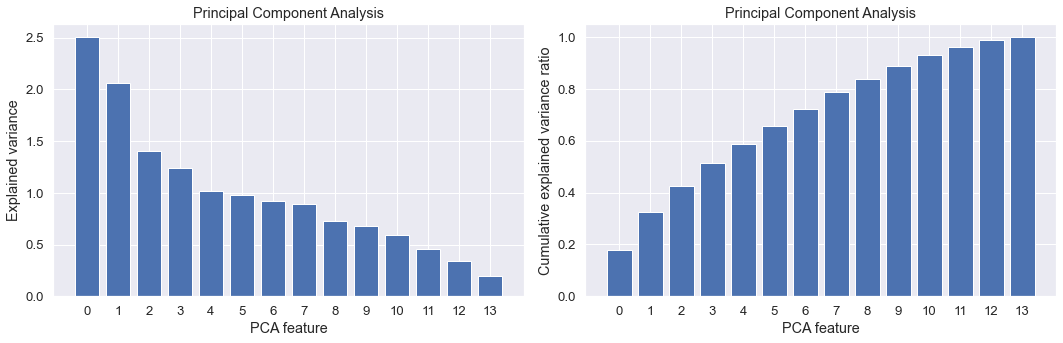

In [30]:
## Principal Component Analysis.
## Defining attributes X and target y.
X_list = ['region_dc_mean', 'region_dc_half_size', 
          'firm_id_26742', 'firm_id_36146', 
          'days_bf_visit', 'visit_month', 
          'contact_weekday', 'visit_weekday', 'visit_hour', 
          'discount', 'tot_rev_fees', 'tot_rev_addons', 
          'q1_bef', 'q2']
X = df.dropna()[X_list].astype(float)
y = df.dropna()['q1_dif3'].astype(float)
## Create train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

## Check the potential for dimensionality reduction using principal component analysis.
## First scaling then transforming.
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
pca = PCA()
pca.fit(X_train_scaled)
X_train_transformed = pca.transform(X_train_scaled)

## Equivalent way using pipeline.
steps = [('scaler_alt', StandardScaler()),
         ('pca_alt', PCA())]
pipeline = Pipeline(steps)
pipeline.fit(X_train)
X_train_transformed_alt = pipeline.transform(X_train)

## Confirm some results.
print('Shape of X_train:', X_train.shape)
print('Shape of X_train_transformed:', X_train_transformed.shape)
print('Shape of X_train_transformed_alt:', X_train_transformed_alt.shape)
checking = X_train_transformed == X_train_transformed_alt
print('Is X_train_transformed the same as X_train_transformed_alt?', checking.all())

## Plot analysis.
fig, ax = plt.subplots(1, 2, figsize=(15,5))
features = range(pca.n_components_)

ax[0].bar(features, pca.explained_variance_)
ax[0].set_xticks(features)
ax[0].set_title('Principal Component Analysis')
ax[0].set_xlabel('PCA feature')
ax[0].set_ylabel('Explained variance')

ax[1].bar(features, np.cumsum(pca.explained_variance_ratio_))
ax[1].set_xticks(features)
ax[1].set_title('Principal Component Analysis')
ax[1].set_xlabel('PCA feature')
ax[1].set_ylabel('Cumulative explained variance ratio')

plt.tight_layout()
plt.show()

There are different possible methods to implement supervised classification: k-nearest neighbors, logistic regression, decision tree and support vector machine. For the sake of simplicity, and because the target variable has more than two categories, we decided to use k-nearest neighbors. Data is preprocessed using StandardScaler to standardize features and PCA to address any remaining multicollinearity and perhaps reduce dimensionality (depending on the optimization algorithm).

The optimized k-NN classifier uses 13 pca components and 18 neighbors. It seems to be good predicting 'q1_dif3' equal to 1 or 0, but it shows deficiency predicting 'q1_dif3' equal to -1. For that category, precision is 0.67 but recall is only 0.04. In dealing with visits causing negative impact, the classifier is decent in the sense that it does not produce many false positives, but it fails in sense that it does produce many false negatives. In other words, when it predicts a negative impact, it is correct 67% of the time, but it correctly identifies only 4% of all negative impacts. The new variable 'q1_dif3_pr' contains the predicted values for the missing data in 'q1_dif3'.

A first look at k-NN: k-nearest neighbors.


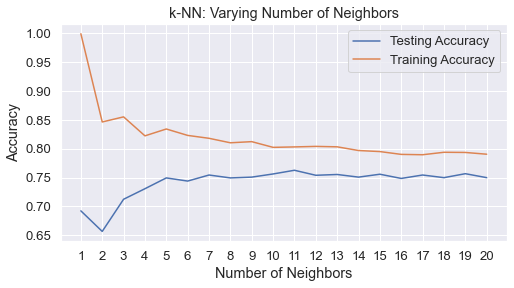

Optimizing k-NN: k-nearest neighbors.
Tuned Model Parameters: {'knn__n_neighbors': 18, 'pca__n_components': 13}

Confusion matrix:
[[  6 109  49]
 [  3 728 112]
 [  0 200 983]]

Accuracy: 0.7840182648401827
Classification report:
              precision    recall  f1-score   support

        -1.0       0.67      0.04      0.07       164
         0.0       0.70      0.86      0.77       843
         1.0       0.86      0.83      0.84      1183

    accuracy                           0.78      2190
   macro avg       0.74      0.58      0.56      2190
weighted avg       0.78      0.78      0.76      2190


Target variable with the inclusion of predicted values:
count    23610.000000
mean         0.526175
std          0.555540
min         -1.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: q1_dif3_pr, dtype: float64


In [31]:
## A first look at k-NN: k-nearest neighbors.
print('A first look at k-NN: k-nearest neighbors.')

## Setup arrays to store train and test accuracies
neighbors = np.arange(1, 21)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
## Loop over different values of k
for i, k in enumerate(neighbors):
    ## Setup a k-NN Classifier with k neighbors: knn
    knn_plot = KNeighborsClassifier(n_neighbors=k)
    ## Fit the classifier to the training data
    knn_plot.fit(X_train, y_train)
    ## Compute accuracy on the training set
    train_accuracy[i] = knn_plot.score(X_train, y_train)
    ## Compute accuracy on the testing set
    test_accuracy[i] = knn_plot.score(X_test, y_test)
## Generate plot
plt.figure(figsize=(8,4))
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xticks(np.arange(1, 21, 1))
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

## Using k-NN: k-nearest neighbors.
print('Optimizing k-NN: k-nearest neighbors.')
## Setup the pipeline.
steps = [('scaler', StandardScaler()),
         ('pca', PCA()),
         ('knn', KNeighborsClassifier())]
pipeline = Pipeline(steps)
## Specify the hyperparameter space.
parameters = {'pca__n_components': np.linspace(1, 14, 14).astype(int),
              'knn__n_neighbors': np.linspace(1, 20, 20).astype(int)}
## Instantiate the GridSearchCV object: cv.
cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)
## Fit to the training set.
cv.fit(X_train, y_train)
## Predict the labels of the test set: y_pred.
y_pred = cv.predict(X_test)
## Compute and print metrics.
print('Tuned Model Parameters: {}'.format(cv.best_params_))
print('\nConfusion matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nAccuracy: {}'.format(cv.score(X_test, y_test)))
print('Classification report:')
print(classification_report(y_test, y_pred))

## Target variable with the inclusion of predicted values.
X_full = df[X_list].astype(float)
list_conditions = [(df['q1_dif3'].notna()), (df['q1_dif3'].isna())]
list_values = [df['q1_dif3'], cv.predict(X_full)]
df['q1_dif3_pr'] = np.select(list_conditions, list_values, default=np.nan)
position = df.columns.get_loc('q1_dif3')+1
col = df.pop('q1_dif3_pr')
df.insert(position, col.name, col)
print('\nTarget variable with the inclusion of predicted values:')
print(df['q1_dif3_pr'].describe())

Because the above k-NN classifier is deficient predicting 'q1_dif3' equal to -1, we decided to try a different approach. We create three binary target variables: 'q1_dif_neg' (for negative impact) which is 1 if 'q1_dif' < 0 and zero otherwise, 'q1_dif_neu' (for neutral impact) which is 1 if 'q1_dif' = 0 and zero otherwise, and 'q1_dif_pos' (for positive impact) which is 1 if 'q1_dif' > 0 and zero otherwise. Then we optimized a k-NN classifier for each of the three binary target variables and use it to predict the missing data in them. The results can be seen below. The new binary variables with the predicted values are 'q1_dif_neg_pr', 'q1_dif_neu_pr' and 'q1_dif_pos_pr'. Unsurprisingly, as the results show, the classifier for 'q1_dif_neg' is not reliable to predict when it should be 1 (precision is 0.67 but recall is only 0.02). The classifiers for 'q1_dif_neu' and 'q1_dif_pos' are fine. More about the new approach coming next.

Target variable: q1_dif_neg
A first look at k-NN: k-nearest neighbors.


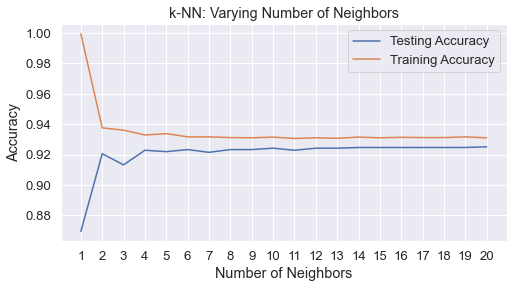

Optimizing k-NN: k-nearest neighbors.
Tuned Model Parameters: {'knn__n_neighbors': 14, 'pca__n_components': 7}

Confusion matrix:
[[2024    2]
 [ 160    4]]

Accuracy: 0.9260273972602739
Classification report:
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      2026
         1.0       0.67      0.02      0.05       164

    accuracy                           0.93      2190
   macro avg       0.80      0.51      0.50      2190
weighted avg       0.91      0.93      0.89      2190



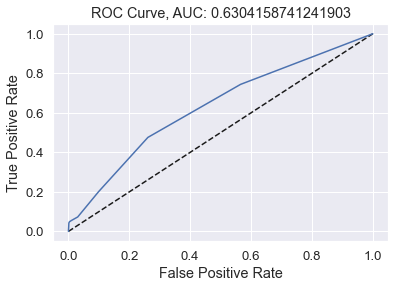


Target variable with the inclusion of predicted values:
count    23610.000000
mean         0.027446
std          0.163383
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: q1_dif_neg_pr, dtype: float64

Target variable: q1_dif_neu
A first look at k-NN: k-nearest neighbors.


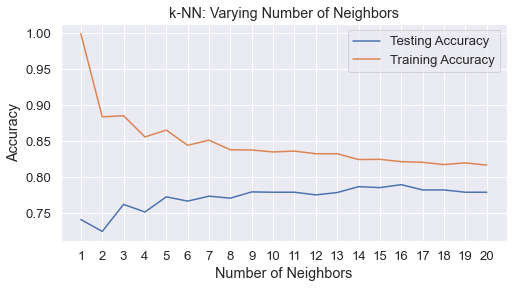

Optimizing k-NN: k-nearest neighbors.
Tuned Model Parameters: {'knn__n_neighbors': 19, 'pca__n_components': 13}

Confusion matrix:
[[1113  234]
 [ 210  633]]

Accuracy: 0.7972602739726027
Classification report:
              precision    recall  f1-score   support

         0.0       0.84      0.83      0.83      1347
         1.0       0.73      0.75      0.74       843

    accuracy                           0.80      2190
   macro avg       0.79      0.79      0.79      2190
weighted avg       0.80      0.80      0.80      2190



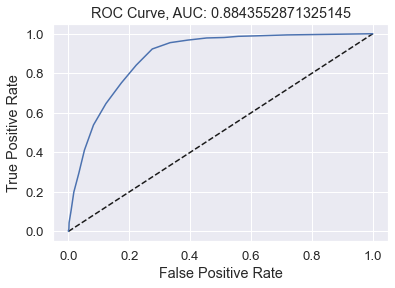


Target variable with the inclusion of predicted values:
count    23610.000000
mean         0.372342
std          0.483439
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: q1_dif_neu_pr, dtype: float64

Target variable: q1_dif_pos
A first look at k-NN: k-nearest neighbors.


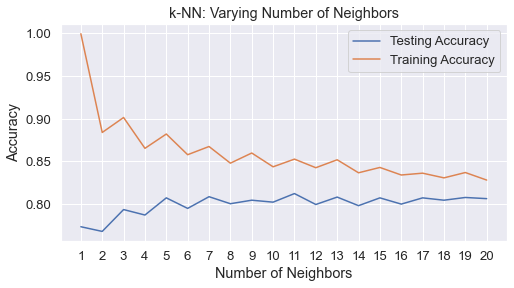

Optimizing k-NN: k-nearest neighbors.
Tuned Model Parameters: {'knn__n_neighbors': 17, 'pca__n_components': 13}

Confusion matrix:
[[881 126]
 [227 956]]

Accuracy: 0.8388127853881279
Classification report:
              precision    recall  f1-score   support

         0.0       0.80      0.87      0.83      1007
         1.0       0.88      0.81      0.84      1183

    accuracy                           0.84      2190
   macro avg       0.84      0.84      0.84      2190
weighted avg       0.84      0.84      0.84      2190



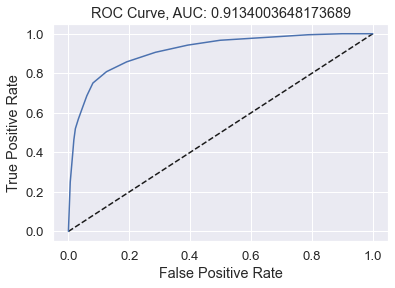


Target variable with the inclusion of predicted values:
count    23610.000000
mean         0.539263
std          0.498467
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: q1_dif_pos_pr, dtype: float64



In [32]:
## Create 'q1_dif3' and change its position in df.
q1_dif = df['q1_dif'].astype(float).fillna(99)
list_conditions = [(q1_dif<0), (q1_dif==0), ((q1_dif>0) & (q1_dif<99))]
list_values_neg = [1, 0, 0]
list_values_neu = [0, 1, 0]
list_values_pos = [0, 0, 1]
df['q1_dif_neg'] = np.select(list_conditions, list_values_neg, default=np.nan)
df['q1_dif_neu'] = np.select(list_conditions, list_values_neu, default=np.nan)
df['q1_dif_pos'] = np.select(list_conditions, list_values_pos, default=np.nan)
df['q1_dif_neg_pr'] = 99  ## Temporary values, they will change later.
df['q1_dif_neu_pr'] = 99
df['q1_dif_pos_pr'] = 99
position = df.columns.get_loc('q1_dif3_pr')+1
for i in ['q1_dif_neg', 'q1_dif_neu', 'q1_dif_pos', 
          'q1_dif_neg_pr', 'q1_dif_neu_pr', 'q1_dif_pos_pr']:
    col = df.pop(i)
    df.insert(position, col.name, col)
    position += 1

## Defining attributes X.
X_list = ['region_dc_mean', 'region_dc_half_size', 
          'firm_id_26742', 'firm_id_36146', 
          'days_bf_visit', 'visit_month', 
          'contact_weekday', 'visit_weekday', 'visit_hour', 
          'discount', 'tot_rev_fees', 'tot_rev_addons', 
          'q1_bef', 'q2']
X = df.dropna()[X_list].astype(float)

## Defining target y.
for target, target_pr in [('q1_dif_neg', 'q1_dif_neg_pr'), 
                          ('q1_dif_neu', 'q1_dif_neu_pr'), 
                          ('q1_dif_pos', 'q1_dif_pos_pr')]:
    y = df.dropna()[target].astype(float)
    ## Create train and test sets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)
    
    ## A first look at k-NN: k-nearest neighbors.
    print('\033[1m'+'Target variable: '+target+'\033[0m')
    print('A first look at k-NN: k-nearest neighbors.')
    ## Setup arrays to store train and test accuracies
    neighbors = np.arange(1, 21)
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))
    ## Loop over different values of k
    for i, k in enumerate(neighbors):
        ## Setup a k-NN Classifier with k neighbors: knn
        knn_plot = KNeighborsClassifier(n_neighbors=k)
        ## Fit the classifier to the training data
        knn_plot.fit(X_train, y_train)
        ## Compute accuracy on the training set
        train_accuracy[i] = knn_plot.score(X_train, y_train)
        ## Compute accuracy on the testing set
        test_accuracy[i] = knn_plot.score(X_test, y_test)
    ## Generate plot
    plt.figure(figsize=(8,4))
    plt.title('k-NN: Varying Number of Neighbors')
    plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
    plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
    plt.legend()
    plt.xticks(np.arange(1, 21, 1))
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.show()

    ## Using k-NN: k-nearest neighbors.
    print('Optimizing k-NN: k-nearest neighbors.')
    ## Setup the pipeline.
    steps = [('scaler', StandardScaler()),
             ('pca', PCA()),
             ('knn', KNeighborsClassifier())]
    pipeline = Pipeline(steps)
    ## Specify the hyperparameter space.
    parameters = {'pca__n_components': np.linspace(1, 14, 14).astype(int),
                  'knn__n_neighbors': np.linspace(1, 20, 20).astype(int)}
    ## Instantiate the GridSearchCV object: cv.
    cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)
    ## Fit to the training set.
    cv.fit(X_train, y_train)
    ## Predict the labels of the test set: y_pred.
    y_pred = cv.predict(X_test)
    ## Compute and print metrics.
    print('Tuned Model Parameters: {}'.format(cv.best_params_))
    print('\nConfusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('\nAccuracy: {}'.format(cv.score(X_test, y_test)))
    print('Classification report:')
    print(classification_report(y_test, y_pred))

    ## Compute predicted probabilities: y_pred_prob
    y_pred_prob = cv.predict_proba(X_test)[:,1]
    ## Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    ## Plot ROC curve with AUC score
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve, AUC: {}'.format(roc_auc_score(y_test, y_pred_prob)))
    plt.show()
            
    ## Target variable with the inclusion of predicted values.
    X_full = df[X_list].astype(float)
    list_conditions = [(df[target].notna()), (df[target].isna())]
    list_values = [df[target], cv.predict(X_full)]
    df[target_pr] = np.select(list_conditions, list_values, default=np.nan)
    print('\nTarget variable with the inclusion of predicted values:')
    print(df[target_pr].describe())
    print()

The new binary variables with the predicted values allow us to reconstruct an alternative to 'q1_dif3_pr', which we will call 'q1_dif3_pr_alt'. It is easy to see how:

- if 'q1_dif_neg_pr' = 0 and 'q1_dif_neu_pr' = 0 and 'q1_dif_pos_pr' = 1, then 'q1_dif3_pr_alt' = 1 (visit had positive impact).
- if 'q1_dif_neg_pr' = 0 and 'q1_dif_neu_pr' = 1 and 'q1_dif_pos_pr' = 0, then 'q1_dif3_pr_alt' = 0 (visit had neutral impact).
- if 'q1_dif_neg_pr' = 1 and 'q1_dif_neu_pr' = 0 and 'q1_dif_pos_pr' = 0, then 'q1_dif3_pr_alt' = -1 (visit had negative impact).

However, because we know that the classifier for 'q1_dif_neg' is not reliable to predict when it should be 1 (more precisely, because we know that the classifier for 'q1_dif_neg' underpredicts 1), we added the following rule:

- if 'q1_dif_neg_pr' = 0 and 'q1_dif_neu_pr' = 0 and 'q1_dif_pos_pr' = 0, then 'q1_dif3_pr_alt' = -1 (visit had negative impact).

In other words, instead of only relying on 'q1_dif_neg_pr' to decide when 'q1_dif3_pr_alt' should be -1, we are also relying on the other two binary variables: when 'q1_dif_neu_pr' says that there was no neutral impact and 'q1_dif_pos_pr' also says that there was no positive impact, then 'q1_dif3_pr_alt' should register that there was negative impact no matter what 'q1_dif_neg_pr' is saying. With the inclusion of that simple rule, we can make predictions for 99.75% of the missing data (only 37 out of the initially 14851 null entries remain missing in 'q1_dif3_pr_alt', or 0.25% of the initial missing data).

Because the remaining missing data is so small, we could just remove those 37 rows, but we opted to maintain them and complete the predictions by just adding the previously predicted information from 'q1_dif3_pr'. In other words, for the remaining missing data, we just did 'q1_dif3_pr_alt' = 'q1_dif3_pr'. The results can been seen below. Only 1473 entries changed value between 'q1_dif3_pr' and 'q1_dif3_pr_alt', with most of them becoming -1 in 'q1_dif3_pr_alt'. Comparing the original distribution of 'q1_dif3', which has 14851 null entries, with the distributions of 'q1_dif3_pr' and 'q1_dif3_pr_alt', both of which having 0 null entries, we can clearly observe that 'q1_dif3_pr' was probably underpredicting -1.

Reconstruction of alternative for 'q1_dif3_pr' named 'q1_dif3_pr_alt'.

Part 1: building it.
14851 null entries initially in 'q1_dif3'.
37 null entries remains in 'q1_dif3_pr_alt'.
0.25% of the initial number of null entries remains.

Part 2: completing it.
14851 null entries initially in 'q1_dif3'.
0 null entries remains in 'q1_dif3_pr_alt'.
0.00% of the initial number of null entries remains.

Different non-null entries between 'q1_dif3_pr' and 'q1_dif3_pr_alt':
        q1_dif3_pr  q1_dif3_pr_alt
count  1473.000000     1473.000000
mean      0.323829       -0.932111
std       0.468095        0.362295
min       0.000000       -1.000000
25%       0.000000       -1.000000
50%       0.000000       -1.000000
75%       1.000000       -1.000000
max       1.000000        1.000000


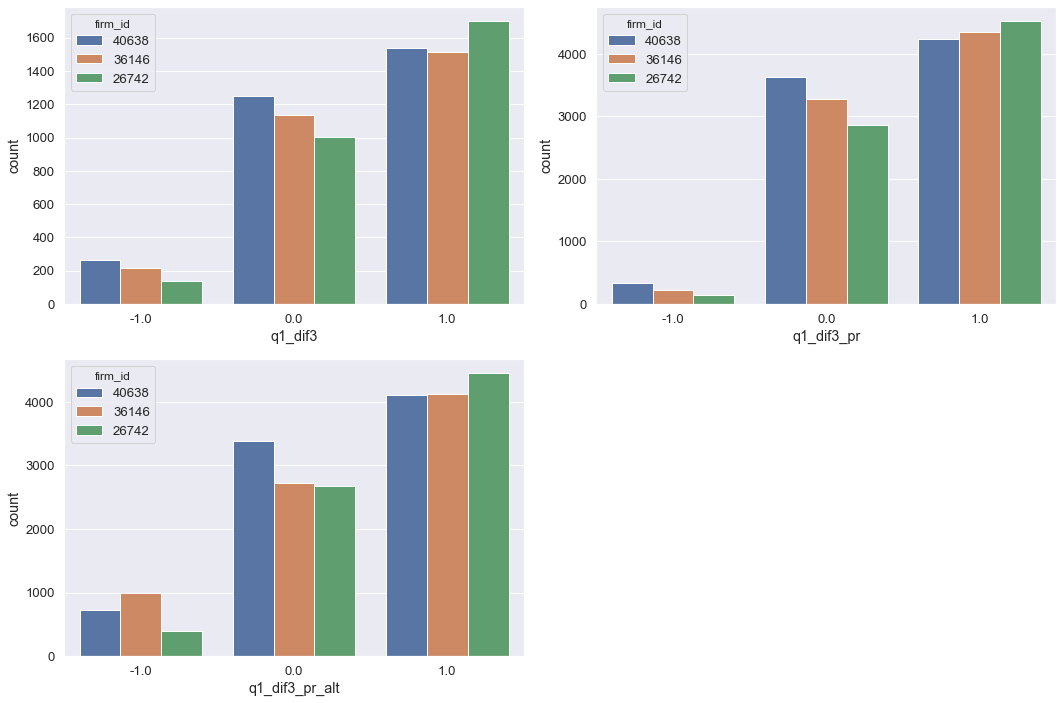

In [33]:
print("Reconstruction of alternative for 'q1_dif3_pr' named 'q1_dif3_pr_alt'.")
print()
## Use 3 2-categories variables to build 1 3-categories variable.
## Where all 2-categories are zero, make it category -1 in the 3-categories.
print('Part 1: building it.')
q1_dif_neg_pr = df['q1_dif_neg_pr']
q1_dif_neu_pr = df['q1_dif_neu_pr']
q1_dif_pos_pr = df['q1_dif_pos_pr']
list_conditions = [((q1_dif_neg_pr==0)&(q1_dif_neu_pr==0)&(q1_dif_pos_pr==0)),
                   ((q1_dif_neg_pr==1)&(q1_dif_neu_pr==0)&(q1_dif_pos_pr==0)),
                   ((q1_dif_neg_pr==0)&(q1_dif_neu_pr==1)&(q1_dif_pos_pr==0)),
                   ((q1_dif_neg_pr==0)&(q1_dif_neu_pr==0)&(q1_dif_pos_pr==1))]
                   #((q1_dif_neg_pr==1)&(q1_dif_neu_pr==1)&(q1_dif_pos_pr==1)),
                   #((q1_dif_neg_pr==1)&(q1_dif_neu_pr==1)&(q1_dif_pos_pr==0)),
                   #((q1_dif_neg_pr==1)&(q1_dif_neu_pr==0)&(q1_dif_pos_pr==1)),
                   #((q1_dif_neg_pr==0)&(q1_dif_neu_pr==1)&(q1_dif_pos_pr==1))]               
list_values = [-1, -1, 0, 1]
df['q1_dif3_pr_alt'] = np.select(list_conditions, list_values, default=np.nan)

## Print information.
n_nan_begin = len(df[df['q1_dif3'].isna()])
n_nan_end = len(df[df['q1_dif3_pr_alt'].isna()])
perc_nan_remain = n_nan_end/n_nan_begin
print(n_nan_begin, "null entries initially in 'q1_dif3'.")
print(n_nan_end, "null entries remains in 'q1_dif3_pr_alt'.")
print(f'{perc_nan_remain:.2%}', "of the initial number of null entries remains.")
print()

## Complete the process of substituting all null-entries.
print('Part 2: completing it.')
list_conditions = [(df['q1_dif3_pr_alt'].notna()), 
                   (df['q1_dif3_pr_alt'].isna())]             
list_values = [df['q1_dif3_pr_alt'], df['q1_dif3_pr']]
df['q1_dif3_pr_alt'] = np.select(list_conditions, list_values, default=np.nan)

## Print information.
n_nan_begin = len(df[df['q1_dif3'].isna()])
n_nan_end = len(df[df['q1_dif3_pr_alt'].isna()])
perc_nan_remain = n_nan_end/n_nan_begin
print(n_nan_begin, "null entries initially in 'q1_dif3'.")
print(n_nan_end, "null entries remains in 'q1_dif3_pr_alt'.")
print(f'{perc_nan_remain:.2%}', "of the initial number of null entries remains.")
print()

## Difference between 'q1_dif3_pr' and 'q1_dif3_pr_alt'.
list_col = ['q1_dif3_pr', 'q1_dif3_pr_alt']
f0 = df['q1_dif3_pr'] != df['q1_dif3_pr_alt']
print("Different non-null entries between 'q1_dif3_pr' and 'q1_dif3_pr_alt':")
print(df[f0][list_col].describe())

## Change position of 'q1_dif3_pr_alt' in df.
position = df.columns.get_loc('q1_dif3_pr')+1
col = df.pop('q1_dif3_pr_alt')
df.insert(position, col.name, col)

## Plot comparative final result.
fig, ax = plt.subplots(2, 2, figsize=(15,10))
_ = sns.countplot(x='q1_dif3', hue='firm_id', hue_order=[40638,36146,26742],
                  data=df, ax=ax[0][0])
_ = sns.countplot(x='q1_dif3_pr', hue='firm_id', hue_order=[40638,36146,26742],
                  data=df, ax=ax[0][1])
_ = sns.countplot(x='q1_dif3_pr_alt', hue='firm_id', hue_order=[40638,36146,26742],
                  data=df, ax=ax[1][0])                                 
ax[-1, -1].axis('off')
plt.tight_layout()                   
plt.show()

Now that we have completed the task of predicting the missing values in the variable 'q1_dif3' by building the variable 'q1_dif3_pr_alt', we can proceed to the next and last task: the identification of groups (clusters) of clients based on the information available about each individual client. In fact, to be more precise, because each entry in our database is actually a booking (that is, a client booking a visit to a firm), we will try to identify groups (clusters) of bookings based on the information available about each individual booking. To carry out this job, we will use unsupervised learning techniques. More specifically, we will use principal component analysis (PCA) and k-means clustering.

Because we will be using k-means, care is necessary when selecting the list of attributes to be included. Basically, they should be on a meaningful numerical scale where distances between observations are not meaningless. Ordinal categorical variables may be included, but nominal categorical variables should not. As a result, we decided to include the following variables as attributes: 

- 'region_dc_mean' and 'region_dc_half_size': these two attributes represent regions (US state, foreign country or unclear) in terms of weekly projected degree centrality value, with the first being the mean and the second being half the size of the 95% confidence interval.

- 'visit_season3': this attribute refers to time, giving the value 0 to winter months, 1 to spring or autumn months, and 2 to summer months. It preserves the cyclical nature of a year's time without creating a artificial distance between, for example, december and january (as we would have if we were to use 12 to represent december and 1 to represent january).

- 'days_bf_visit', 'guests' and 'tot_rev_addons': they are all numeric variables by nature, so no issues here.

- 'q1_bef', 'q1_dif3_pr_alt' and 'q2': these are ordinal categorical variables. 'q1_bef' shows the likelihood to recommend the firm's product before visit on a scale 0 to 10. 'q1_dif3_pr_alt' shows if the visit had a negative (-1), neutral (0) or positive (1) impact on the client. 'q2' shows how often the client has used the firm's product in the past year on a scale 0 (never) to 3 (at least once a week).

Having chosen those 9 attributes, we used PCA to reduce the dimensionality from nine to two and plot the result. It is important to mention that the attributes were standardized prior to PCA using Sklearn's StandardScaler, which standardizes attributes by removing the mean and scaling to unit variance. According to the results, two dimensions account for 41.8% of the variance (the cumulative explained variance ratio). The scatter plot doesn't show clear distinct clusters, but a case could be made for four clusters.

In [34]:
## Create 3 season categories with spring and autumn in the same category.
## 0 = winter, 1 = spring or autumn, 2 = summer.
seasons = [0, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 0]
month_to_season = dict(zip(range(1,13), seasons))
## Season at the time of the contact.
df['contact_season3'] = df['contact_month'].map(month_to_season)
position = df.columns.get_loc('contact_month')+1
col = df.pop('contact_season3')
df.insert(position, col.name, col)
## Season at the time of the visit.
df['visit_season3'] = df['visit_month'].map(month_to_season)
position = df.columns.get_loc('visit_month')+1
col = df.pop('visit_season3')
df.insert(position, col.name, col)

## Full list of attributes X for pos unsupervised classification.
X_uc_full_list = ['region_dc_mean', 'region_dc_half_size', 
                  'firm_id_26742', 'firm_id_36146', 'firm_id_40638',
                  'contact_month', 'visit_month', 
                  'contact_season3', 'visit_season3',
                  'contact_weekday', 'visit_weekday', 
                  'days_bf_visit', 'visit_hour',
                  'discount', 'guests', 
                  'tot_rev_fees', 'tot_rev_addons',
                  'q1_bef', 'q1_dif3_pr_alt', 'q2']
              
## List of attributes X to be used in unsupervised classification.
X_uc_list = ['region_dc_mean', 'region_dc_half_size', 
             'visit_season3', 'days_bf_visit', 
             'guests', 'tot_rev_addons', 
             'q1_bef', 'q1_dif3_pr_alt', 'q2']

## Dataframe of attributes X to be used in unsupervised classification.
X_uc = df[X_uc_list].astype(float)

## Create train and test sets.
#X_uc_train, X_uc_test = train_test_split(X_uc, test_size=0.25, random_state=5) 

Shape of X: (23610, 9)
Shape of X_transformed: (23610, 2)
Shape of X_transformed_alt: (23610, 2)
Is X_transformed the same as X_transformed_alt? True

PCA 2 features' explained variance: [2.04303589 1.71943262]
PCA 2 features' cumulative explained variance ratio: [0.22699437 0.41803435]


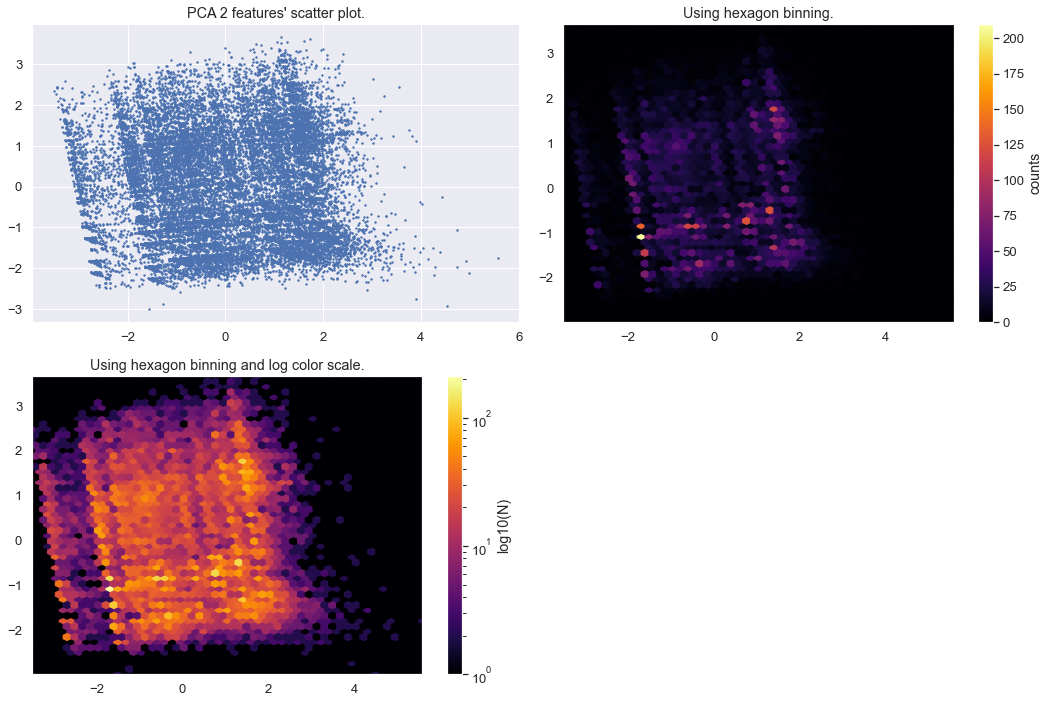

In [35]:
### First analysis using principal component analysis (PCA).
X = X_uc

## First scaling then transforming.
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
pca = PCA(n_components=2, svd_solver='full')
pca.fit(X_scaled)
X_transformed = pca.transform(X_scaled)

## Equivalent way using pipeline.
steps = [('scaler_alt', StandardScaler()),
         ('pca_alt', PCA(n_components=2, svd_solver='full'))]
pipeline = Pipeline(steps)
pipeline.fit(X)
X_transformed_alt = pipeline.transform(X)

## Confirm some results.
print('Shape of X:', X.shape)
print('Shape of X_transformed:', X_transformed.shape)
print('Shape of X_transformed_alt:', X_transformed_alt.shape)
checking = X_transformed == X_transformed_alt
print('Is X_transformed the same as X_transformed_alt?', checking.all())
print()
print("PCA 2 features' explained variance:", 
      pca.explained_variance_)
print("PCA 2 features' cumulative explained variance ratio:", 
      np.cumsum(pca.explained_variance_ratio_))

xs = X_transformed[:,0]
ys = X_transformed[:,1]
xmin = xs.min()
xmax = xs.max()
ymin = ys.min()
ymax = ys.max()

## Plot PCA 2 dimensions.
## Reference: https://matplotlib.org/3.1.0/gallery/statistics/hexbin_demo.html
fig, ax = plt.subplots(2, 2, figsize=(15,10))

ax[0,0].scatter(xs, ys, s=2)
ax[0,0].set_title("PCA 2 features' scatter plot.")

hb = ax[0,1].hexbin(xs, ys, gridsize=50, cmap='inferno')
ax[0,1].axis([xmin, xmax, ymin, ymax])
ax[0,1].set_title('Using hexagon binning.')
cb = fig.colorbar(hb, ax=ax[0,1])
cb.set_label('counts')

hb = ax[1,0].hexbin(xs, ys, gridsize=50, bins='log', cmap='inferno')
ax[1,0].axis([xmin, xmax, ymin, ymax])
ax[1,0].set_title('Using hexagon binning and log color scale.')
cb = fig.colorbar(hb, ax=ax[1,0])
cb.set_label('log10(N)')
                   
ax[-1, -1].axis('off')
plt.tight_layout()                   
plt.show()

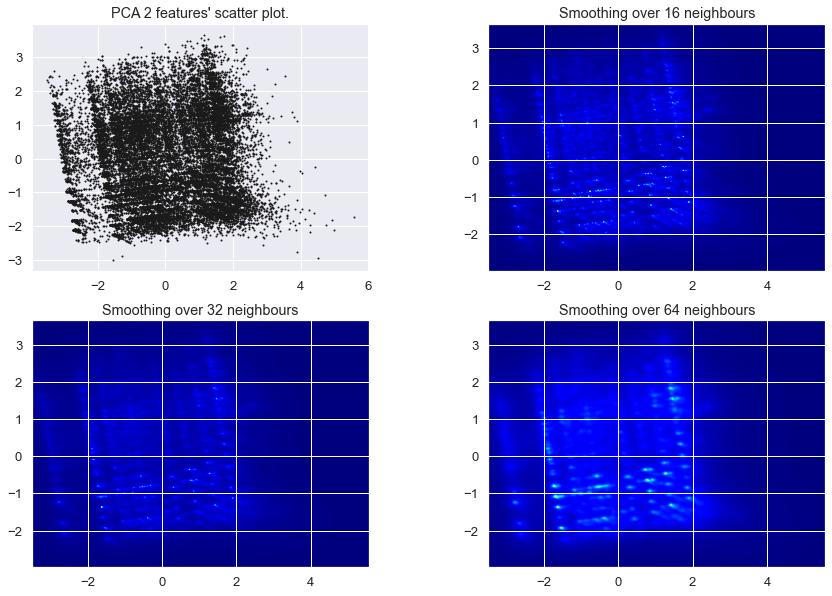

In [36]:
## Alternative visualization of the PCA 2 features' scatter plot.
## Reference: https://stackoverflow.com/a/47350350
import matplotlib.cm as cm

def data_coord2view_coord(p, vlen, pmin, pmax):
    dp = pmax - pmin
    dv = (p - pmin) / dp * vlen
    return dv

def nearest_neighbours(xs, ys, reso, n_neighbours):
    im = np.zeros([reso, reso])
    extent = [np.min(xs), np.max(xs), np.min(ys), np.max(ys)]
    xv = data_coord2view_coord(xs, reso, extent[0], extent[1])
    yv = data_coord2view_coord(ys, reso, extent[2], extent[3])
    for x in range(reso):
        for y in range(reso):
            xp = (xv - x)
            yp = (yv - y)
            d = np.sqrt(xp**2 + yp**2)
            im[y][x] = 1 / np.sum(d[np.argpartition(d.ravel(), n_neighbours)[:n_neighbours]])
    return im, extent

## Make the plots.
xs = X_transformed[:,0]
ys = X_transformed[:,1]
resolution = 250

fig, axes = plt.subplots(2, 2, figsize=(15,10))
for ax, neighbours in zip(axes.flatten(), [0, 16, 32, 64]):
    if neighbours == 0:
        ax.plot(xs, ys, 'k.', markersize=2)
        ax.set_aspect('equal')
        ax.set_title("PCA 2 features' scatter plot.")
    else:
        im, extent = nearest_neighbours(xs, ys, resolution, neighbours)
        ax.imshow(im, origin='lower', extent=extent, cmap=cm.jet)
        ax.set_title("Smoothing over %d neighbours" % neighbours)
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
plt.show()

After PCA, the other unsupervised learning technique we implemented was k-means clustering. Again, prior to k-means, the attributes were standardized using Sklearn's StandardScaler. However, because the PCA analysis showed that two dimensions accounts for only 41.8% of the variance (with not much more gain by adding a third or even a forth dimension), we first opted to implement k-means without reducing dimensionality. Unfortunately, the results this time were even less clear: as we increase the number of clusters in order to find the optimal number of clusters, the sum of squared distances (errors) didn't show any evident "elbow", and the plot of the (mean) silhouette scores looked like a roller coast, which is not helpful. 

Is X_labels the same as X_labels_alt1? True
Is X_labels the same as X_labels_alt2? True
Is X_labels_alt1 the same as X_labels_alt2? True


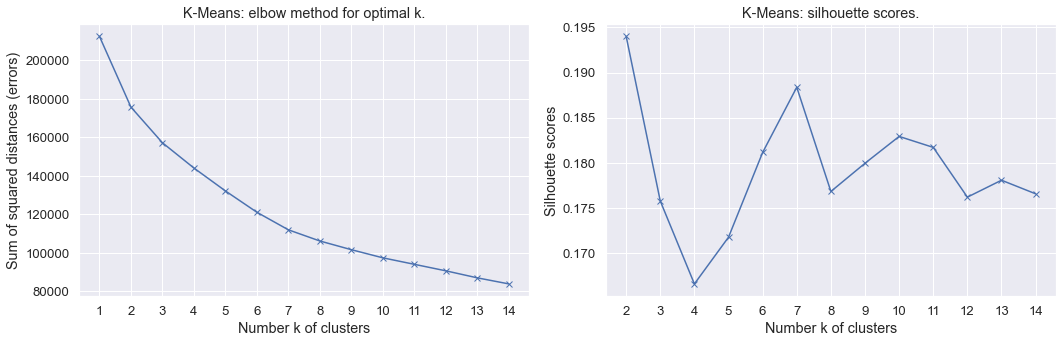

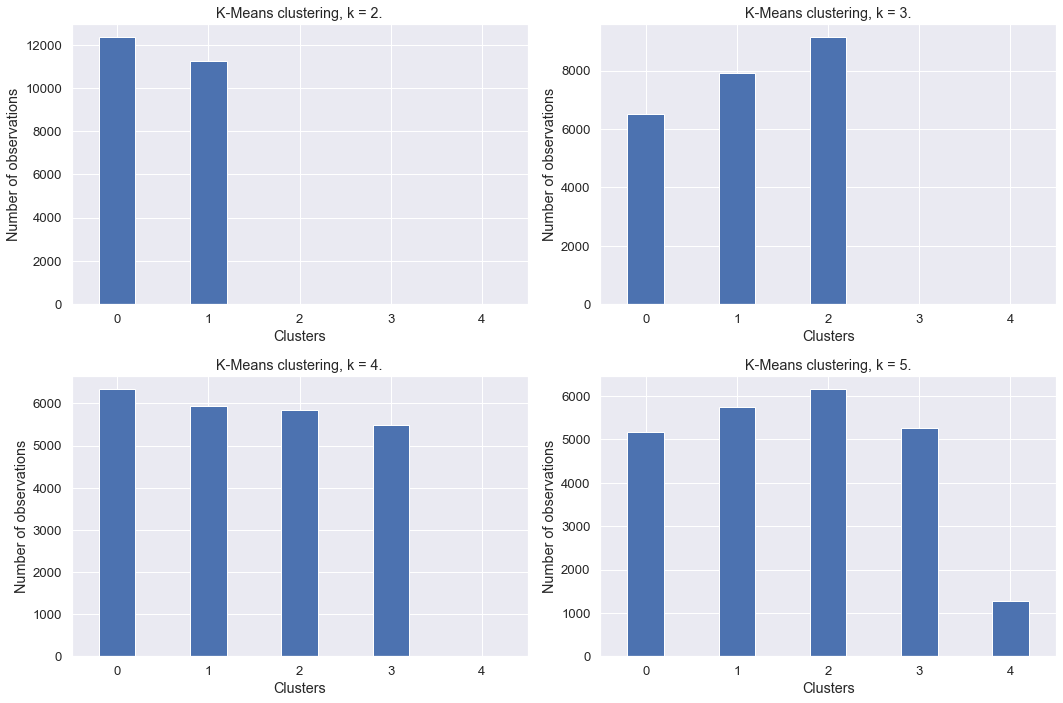

In [37]:
### Second analysis using KMeans.

## First scaling then predicting.
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
kmeans = KMeans(random_state=5)
kmeans.fit(X_scaled)
X_labels = kmeans.predict(X_scaled)

## Equivalent way using pipeline.
steps = [('scaler_alt1', StandardScaler()),
         ('kmeans_alt1', KMeans(random_state=5))]
pipeline = Pipeline(steps)
pipeline.fit(X)
X_labels_alt1 = pipeline.predict(X)

## Equivalent way using make_pipeline.
scaler_alt2 = StandardScaler()
kmeans_alt2 = KMeans(random_state=5)
pipeline2 = make_pipeline(scaler_alt2, kmeans_alt2)
pipeline2.fit(X)
X_labels_alt2 = pipeline2.predict(X)

## Confirm some results.
checking1 = X_labels == X_labels_alt1
checking2 = X_labels == X_labels_alt2
checking3 = X_labels_alt1 == X_labels_alt2
print('Is X_labels the same as X_labels_alt1?', checking1.all())
print('Is X_labels the same as X_labels_alt2?', checking2.all())
print('Is X_labels_alt1 the same as X_labels_alt2?', checking3.all())

sum_of_squared_distances = []
silhouette_scores=[]
K = np.arange(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=5)
    kmeans.fit(X_scaled)
    sum_of_squared_distances.append(kmeans.inertia_)
    if k >= 2:
        labels=kmeans.labels_
        silhouette_scores.append(silhouette_score(X_scaled, labels))

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(K, sum_of_squared_distances, 'bx-')
ax[0].set_xticks(np.arange(1,15,1))
ax[0].set_xlabel('Number k of clusters')
ax[0].set_ylabel('Sum of squared distances (errors)')
ax[0].set_title('K-Means: elbow method for optimal k.')
ax[1].plot(np.delete(K, 0), silhouette_scores, 'bx-')
ax[1].set_xticks(np.arange(2,15,1))
ax[1].set_xlabel('Number k of clusters')
ax[1].set_ylabel('Silhouette scores')
ax[1].set_title('K-Means: silhouette scores.')
plt.tight_layout()
plt.show()    

fig, ax = plt.subplots(2, 2, figsize=(15,10))
# Sum of squared errors seems to decrease at a constant rate as k increases. 
# No clear 'elbow' point, so it is hard to choose one k.
# Taking k as 5 as a possibility.
for i, j, k in [(0, 0, 2), (0, 1, 3), (1, 0, 4), (1, 1, 5)]:
    kmeans = KMeans(n_clusters=k, random_state=5)
    kmeans.fit(X_scaled)
    labels = kmeans.predict(X_scaled)
    clusters, counts = np.unique(labels, return_counts=True)
    ## Make the plots
    ax[i,j].bar(clusters, counts, align = 'center', width=0.4)
    ax[i,j].set_xlim((-0.5, 4.5))
    ax[i,j].set_xticks([0, 1, 2, 3, 4])
    ax[i,j].set_xlabel('Clusters')
    ax[i,j].set_ylabel('Number of observations')
    ax[i,j].set_title('K-Means clustering, k = %d.' %k)
plt.tight_layout()
plt.show()

For n_clusters = 2 the average silhouette_score is 0.19401360244352064
For n_clusters = 3 the average silhouette_score is 0.1757705866902498
For n_clusters = 4 the average silhouette_score is 0.16658684736310678
For n_clusters = 5 the average silhouette_score is 0.17176140580932422


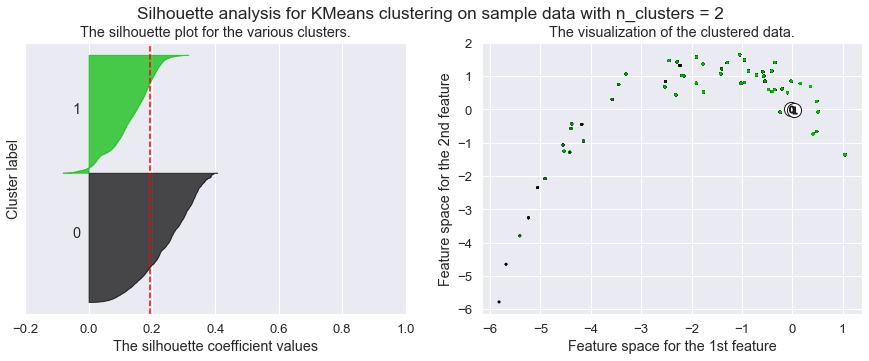

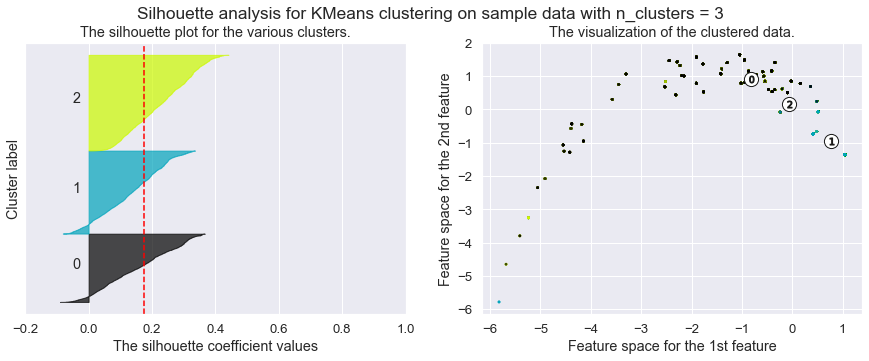

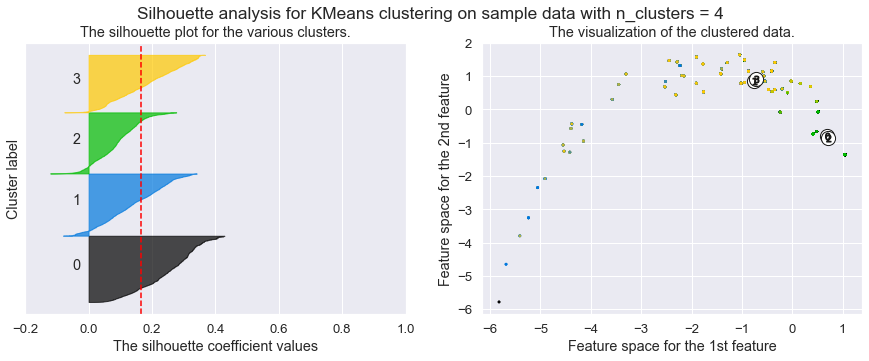

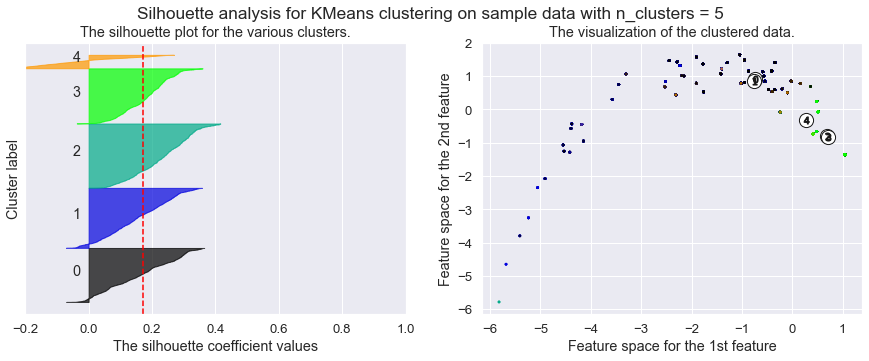

In [38]:
## Silhouette analysis for KMeans clustering.
## Reference: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
X_input = X_scaled
range_n_clusters = [2, 3, 4, 5]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=5)
    cluster_labels = clusterer.fit_predict(X_input)
    ## The silhouette_score gives the average value for all the samples.
    ## It gives a perspective into density and separation of the formed clusters.
    silhouette_avg = silhouette_score(X_input, cluster_labels)
    print('For n_clusters =', n_clusters,
          'the average silhouette_score is', silhouette_avg)
    ## Compute the silhouette scores for each sample.
    sample_silhouette_values = silhouette_samples(X_input, cluster_labels)
    
    ## Create subplots with 1 row and 2 columns.
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    #fig.set_size_inches(18, 7)
    plt.suptitle(('Silhouette analysis for KMeans clustering on sample data '
                  'with n_clusters = %d' % n_clusters))
    
    ## The 1st subplot is the silhouette plot.
    y_lower = 10
    for i in range(n_clusters):
        ## Aggregate & sort silhouette scores for samples belonging to cluster i.
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax[0].fill_betweenx(np.arange(y_lower, y_upper), 
                            0, ith_cluster_silhouette_values, 
                            facecolor=color, edgecolor=color, alpha=0.7)
        ## Label the silhouette plots with their cluster numbers at the middle.
        ax[0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        ## Compute the new y_lower for next plot.
        y_lower = y_upper + 10  ## 10 for the 0 samples.
    ax[0].set_xlim([-0.2, 1]) ## Silhouette coefficients can range from -1 to 1. 
    ## (n_clusters+1)*10 is for inserting blank space between silhouette plots
    ## of individual clusters, to demarcate them clearly.
    #ax[0].set_ylim([0, len(X_input) + (n_clusters + 1) * 10])
    ax[0].set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax[0].set_yticks([])  ## Clear the yaxis labels and ticks.
    ## The vertical line for average silhouette score of all the values.
    ax[0].axvline(x=silhouette_avg, color='red', linestyle='--')
    ax[0].set_xlabel('The silhouette coefficient values')
    ax[0].set_ylabel('Cluster label')
    ax[0].set_title('The silhouette plot for the various clusters.')

    ## The 2nd subplot shows the actual clusters formed.
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax[1].scatter(X_input[:, 0], X_input[:, 1], marker='.', s=30, lw=0, 
                  c=colors, alpha=0.7, edgecolor='k')
    ## Labeling the clusters.
    centers = clusterer.cluster_centers_
    ## Draw white circles at cluster centers.
    ax[1].scatter(centers[:, 0], centers[:, 1], marker='o', s=200,
                  c="white", alpha=1, edgecolor='k')
    for i, c in enumerate(centers):
        ax[1].scatter(c[0], c[1], marker='$%d$' % i, s=50, 
                      alpha=1, edgecolor='k')
    ax[1].set_xlabel('Feature space for the 1st feature')
    ax[1].set_ylabel('Feature space for the 2nd feature')
    ax[1].set_title('The visualization of the clustered data.')
    
plt.show()

Since the k-means results without reducing dimensionality were not clear, we decided to implement k-means again but using PCA after the standardization of the attributes in order to reduce the dimensionality to two, despite the fact that two dimensions accounts for only 41.8% of the variance. This time the results were much clearer: for increasing number of clusters, the sum of squared distances (errors) show an "elbow" with 4 clusters, and the plot of the (mean) silhouette scores also shows a maximum with 4 clusters, although the value of 0.42 for average silhouette score (closer to 0 than 1) suggests a weak cluster structure (clusters close to each other that could be artificial). With 4 clusters, there is very few negative silhoute scores and the number of observations in each cluster also seems similar and, therefore, reasonable.

It is important to keep in mind two observations:

- The cluster structure with 4 clusters that we found accounts for only 41.8% of the variance. It may be possible to obtain better results if outliers are first identified and discharged before the k-means implementation.
- Regardless of the possible influence of outliers, the cluster structure with 4 clusters is weak because the suggested clusters are close to each other and the result does not rule out the possibility that there is actually only one cluster.

Shape of X: (23610, 9)
Shape of X_transformed: (23610, 2)
Shape of X_transformed_alt: (23610, 2)
Is X_transformed the same as X_transformed_alt? True


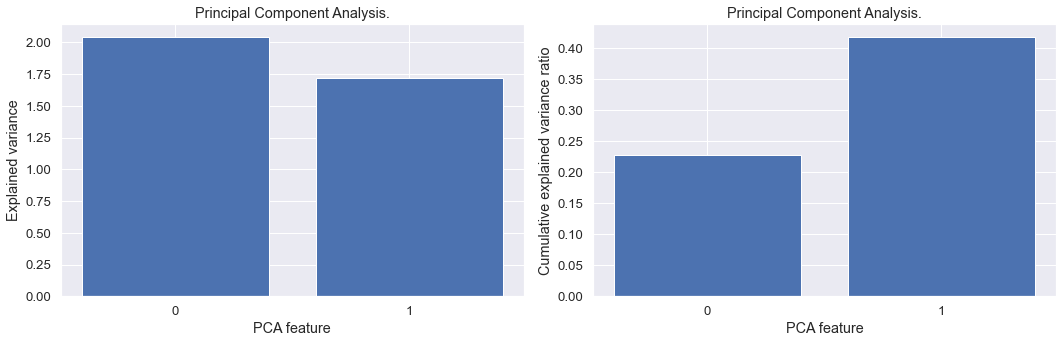

In [39]:
## Principal Component Analysis.
## First scaling then transforming.
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
pca = PCA(n_components=2, svd_solver='full')
pca.fit(X_scaled)
X_transformed = pca.transform(X_scaled)

## Equivalent way using pipeline.
steps = [('scaler_alt', StandardScaler()),
         ('pca_alt', PCA(n_components=2, svd_solver='full'))]
pipeline = Pipeline(steps)
pipeline.fit(X)
X_transformed_alt = pipeline.transform(X)

## Confirm some results.
print('Shape of X:', X.shape)
print('Shape of X_transformed:', X_transformed.shape)
print('Shape of X_transformed_alt:', X_transformed_alt.shape)
checking = X_transformed == X_transformed_alt
print('Is X_transformed the same as X_transformed_alt?', checking.all())

## Plot analysis.
fig, ax = plt.subplots(1, 2, figsize=(15,5))
features = range(pca.n_components_)

ax[0].bar(features, pca.explained_variance_)
ax[0].set_xticks(features)
ax[0].set_title('Principal Component Analysis.')
ax[0].set_xlabel('PCA feature')
ax[0].set_ylabel('Explained variance')

ax[1].bar(features, np.cumsum(pca.explained_variance_ratio_))
ax[1].set_xticks(features)
ax[1].set_title('Principal Component Analysis.')
ax[1].set_xlabel('PCA feature')
ax[1].set_ylabel('Cumulative explained variance ratio')

plt.tight_layout()
plt.show()

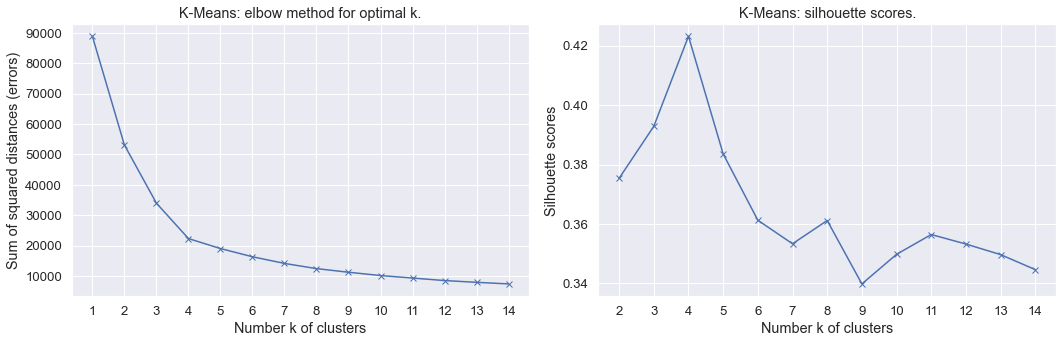

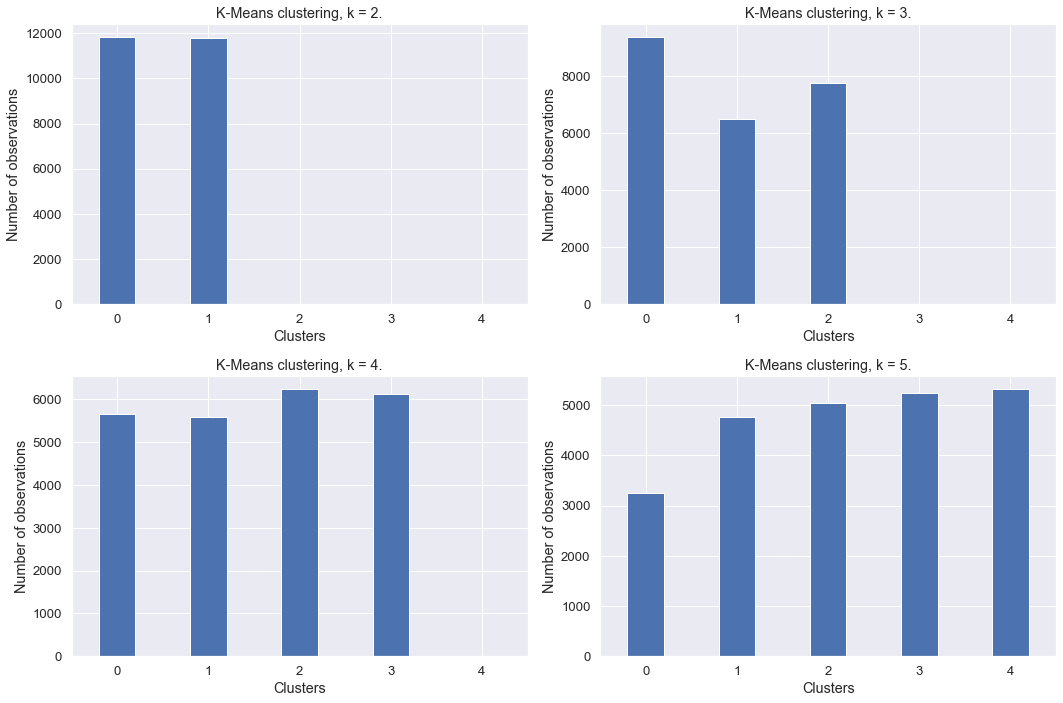

In [40]:
### Analysis using KMeans with PCA transformed data.
## Reference: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
sum_of_squared_distances = []
silhouette_scores = []
K = np.arange(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=5)
    kmeans.fit(X_transformed)
    sum_of_squared_distances.append(kmeans.inertia_)
    if k >= 2:
        labels=kmeans.labels_
        silhouette_scores.append(silhouette_score(X_transformed, labels))

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(K, sum_of_squared_distances, 'bx-')
ax[0].set_xticks(np.arange(1,15,1))
ax[0].set_xlabel('Number k of clusters')
ax[0].set_ylabel('Sum of squared distances (errors)')
ax[0].set_title('K-Means: elbow method for optimal k.')
ax[1].plot(np.delete(K, 0), silhouette_scores, 'bx-')
ax[1].set_xticks(np.arange(2,15,1))
ax[1].set_xlabel('Number k of clusters')
ax[1].set_ylabel('Silhouette scores')
ax[1].set_title('K-Means: silhouette scores.')
plt.tight_layout()
plt.show()    

fig, ax = plt.subplots(2, 2, figsize=(15,10))
# Sum of squared errors seems to decrease at a constant rate as k increases. 
# No clear 'elbow' point, so it is hard to choose one k.
# Taking k as 5 as a possibility.
for i, j, k in [(0, 0, 2), (0, 1, 3), (1, 0, 4), (1, 1, 5)]:
    kmeans = KMeans(n_clusters=k, random_state=5)
    kmeans.fit(X_transformed)
    labels = kmeans.predict(X_transformed)
    clusters, counts = np.unique(labels, return_counts=True)
    ## Make the plots
    ax[i,j].bar(clusters, counts, align = 'center', width=0.4)
    ax[i,j].set_xlim((-0.5, 4.5))
    ax[i,j].set_xticks([0, 1, 2, 3, 4])
    ax[i,j].set_xlabel('Clusters')
    ax[i,j].set_ylabel('Number of observations')
    ax[i,j].set_title('K-Means clustering, k = %d.' %k)
plt.tight_layout()
plt.show()

For n_clusters = 2 the average silhouette_score is 0.37536355617078754
For n_clusters = 3 the average silhouette_score is 0.392843739203731
For n_clusters = 4 the average silhouette_score is 0.4231286110589565
For n_clusters = 5 the average silhouette_score is 0.3835863057123101


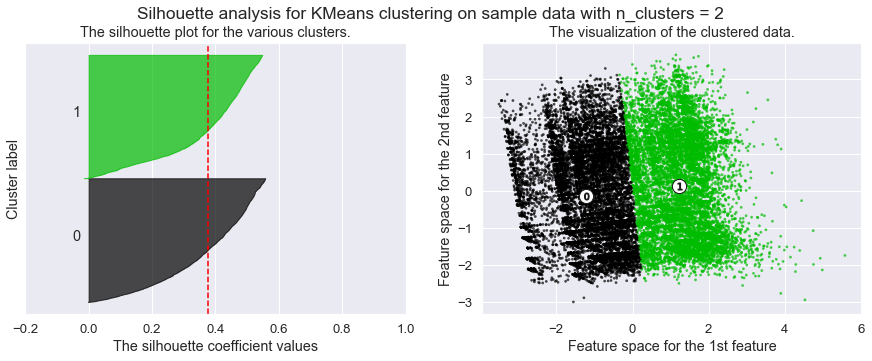

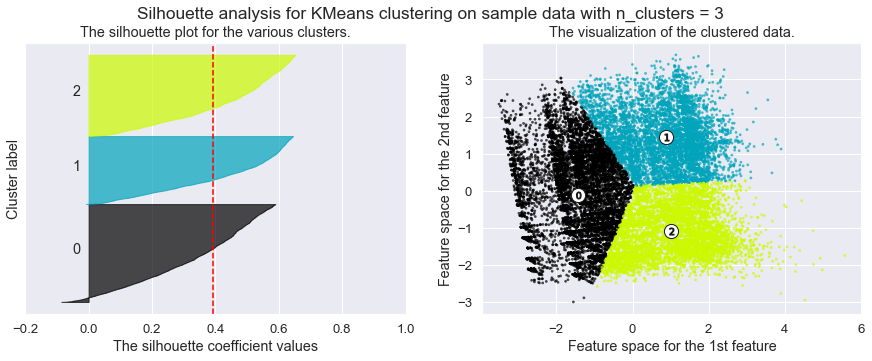

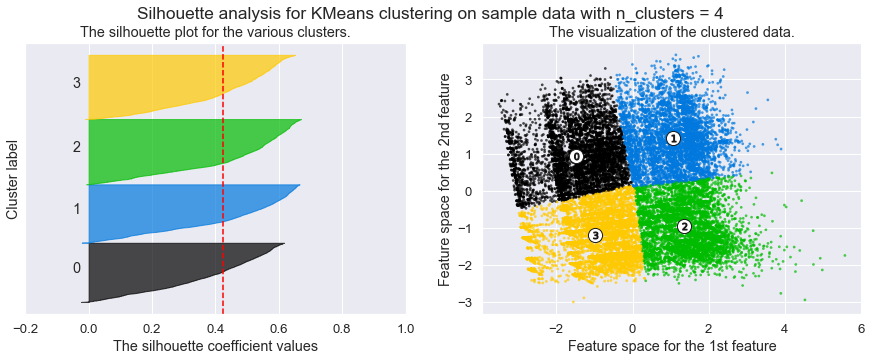

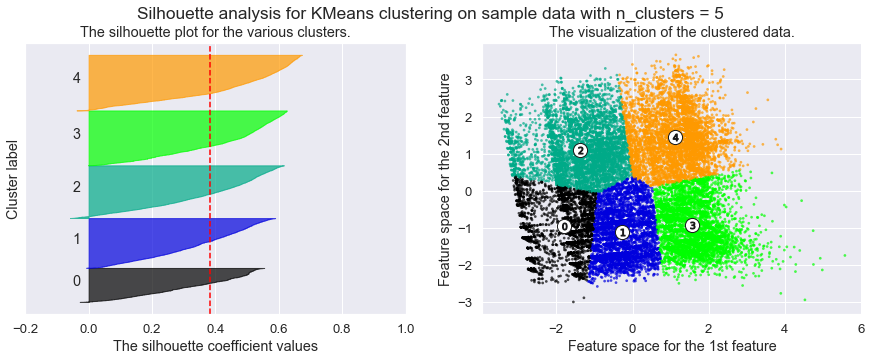

In [41]:
## Silhouette analysis for KMeans clustering.
## Reference: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
X_input = X_transformed
range_n_clusters = [2, 3, 4, 5]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=5)
    cluster_labels = clusterer.fit_predict(X_input)
    ## The silhouette_score gives the average value for all the samples.
    ## It gives a perspective into density and separation of the formed clusters.
    silhouette_avg = silhouette_score(X_input, cluster_labels)
    print('For n_clusters =', n_clusters,
          'the average silhouette_score is', silhouette_avg)
    ## Compute the silhouette scores for each sample.
    sample_silhouette_values = silhouette_samples(X_input, cluster_labels)
    
    ## Create subplots with 1 row and 2 columns.
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    #fig.set_size_inches(18, 7)
    plt.suptitle(('Silhouette analysis for KMeans clustering on sample data '
                  'with n_clusters = %d' % n_clusters))
    
    ## The 1st subplot is the silhouette plot.
    y_lower = 10
    for i in range(n_clusters):
        ## Aggregate & sort silhouette scores for samples belonging to cluster i.
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax[0].fill_betweenx(np.arange(y_lower, y_upper), 
                            0, ith_cluster_silhouette_values, 
                            facecolor=color, edgecolor=color, alpha=0.7)
        ## Label the silhouette plots with their cluster numbers at the middle.
        ax[0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        ## Compute the new y_lower for next plot.
        y_lower = y_upper + 10  ## 10 for the 0 samples.
    ax[0].set_xlim([-0.2, 1]) ## Silhouette coefficients can range from -1 to 1. 
    ## (n_clusters+1)*10 is for inserting blank space between silhouette plots
    ## of individual clusters, to demarcate them clearly.
    #ax[0].set_ylim([0, len(X_input) + (n_clusters + 1) * 10])
    ax[0].set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax[0].set_yticks([])  ## Clear the yaxis labels and ticks.
    ## The vertical line for average silhouette score of all the values.
    ax[0].axvline(x=silhouette_avg, color='red', linestyle='--')
    ax[0].set_xlabel('The silhouette coefficient values')
    ax[0].set_ylabel('Cluster label')
    ax[0].set_title('The silhouette plot for the various clusters.')

    ## The 2nd subplot shows the actual clusters formed.
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax[1].scatter(X_input[:, 0], X_input[:, 1], marker='.', s=30, lw=0, 
                  c=colors, alpha=0.7, edgecolor='k')
    ## Labeling the clusters.
    centers = clusterer.cluster_centers_
    ## Draw white circles at cluster centers.
    ax[1].scatter(centers[:, 0], centers[:, 1], marker='o', s=200,
                  c="white", alpha=1, edgecolor='k')
    for i, c in enumerate(centers):
        ax[1].scatter(c[0], c[1], marker='$%d$' % i, s=50, 
                      alpha=1, edgecolor='k')
    ax[1].set_xlabel('Feature space for the 1st feature')
    ax[1].set_ylabel('Feature space for the 2nd feature')
    ax[1].set_title('The visualization of the clustered data.')
    
plt.show()

Below we characterize the four clusters with regard to some attributes:

- In terms of most often value (mode), the four clusters seem to distinguish the four categories in question 'q2', which asks how often the client used the product in the past year:
    - Cluster 0 is mainly composed by 'q2' = 0, clients who never used the product in the past year (closely followed by 'q2' = 1, those who used it only occasionaly, see last table with frequencies).
    - Cluster 1 is mainly composed by 'q2' = 3, clients who used the product at least once a week (they can be said to be fans).
    - Cluster 2 is mainly composed by 'q2' = 2, clients who used the product at least once a month (closely followed by 'q2' = 1, those who used it only occasionaly).
    - Cluster 3 is mainly composed by 'q2' = 1, clients who used the product only occasionaly (followed by 'q2' = 0, those who never used it, so clusters 0 and 3 are similar in that regard).


- Clusters 0 and 1 are mainly associated with 'firm_id' 40638 and 'us_region' MO (where the firm is located). Cluster 0 mostly contains clients who would give the product grade 5 out of 10 (question 'q1_bef') before the visit, with that grade improving after the visit (variable 'q1_dif3_pr_alt'). Cluster 1 mostly contains clients who would give the product grade 10 out of 10 before the visit, with that grade remaining the same after the visit.


- Cluster 2 is mainly associated with 'firm_id' 36146 and 'us_region' CA (where the firm is located). Cluster 3 is mainly associated with 'firm_id' 26742 but also with 'us_region' CA (instead of CO where the firm is located). That happens because cluster 3 is weakly associated with 'firm_id' 26742 and could also be associated with 'firm_id' 36146 (see the table with frequencies at the bottom). Therefore, cluster 3 is also connected to 'firm_id 36146'.


- Cluster 2, like cluster 1, mostly contains clients who would give the product grade 10 out of 10 before the visit, with that grade remaining the same after the visit. Cluster 3, like cluster 0, mostly contains clients who would give the product grade 5 out of 10 before the visit, with that grade improving after the visit.

In summary, there is evidence to say that, in general, customers who used and valued the product poorly before the visit improved their evaluation of the product after the visit. Customers who already used and valued the product well before the visit maintained their evaluation of the product after the visit.

In [42]:
## KMeans with the selected number of clusters.
kmeans = KMeans(n_clusters=4, random_state=5)
kmeans.fit(X_transformed)
labels = kmeans.predict(X_transformed)
silhouette_avg = silhouette_score(X_transformed, labels)
print('\033[1m' + 'For n_clusters = 4 the average silhouette_score is %.4f.' 
      % silhouette_avg + '\033[0m')

## Add column with predicted labels to dataframe df.
df['kmeans_labels'] = labels

## Analyze labels vs. attributes to find out the characteristics of labels.
df_sub = df[X_uc_full_list + ['kmeans_labels']].astype(float)
for i in X_uc_full_list:
    tb = df_sub.groupby(['kmeans_labels'])[[i]].agg([pd.Series.mode, pd.Series.mean, pd.Series.std])
    print(40*'- ')
    print(tb)

For n_clusters = 4 the average silhouette_score is 0.4231.
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
              region_dc_mean                    
                        mode      mean       std
kmeans_labels                                   
0.0                 0.663864  0.638999  0.118253
1.0                 0.663864  0.641655  0.106955
2.0                 0.857353  0.818664  0.036751
3.0                 0.857353  0.811563  0.039506
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
              region_dc_half_size                    
                             mode      mean       std
kmeans_labels                                        
0.0                      0.102117  0.100836  0.004985
1.0                      0.102117  0.101270  0.004261
2.0                      0.079566  0.084442  0.005411
3.0                      0.079566  0.085276  0.005507
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [43]:
## Find most frequent value of a categorical variable for each kmeans label.
col_list = ['kmeans_labels', 'firm_id', 'us_region', 
            'contact_month', 'visit_month', 
            'q1_bef', 'q1_dif3_pr_alt', 'q2']

dic_ct_max = defaultdict(list)
for i in col_list:
    ct = pd.crosstab(df['kmeans_labels'], df[i])
    mx = ct.idxmax(axis='columns')
    for j in list(mx.values):
        dic_ct_max[i].append(j)

df_ct_max = pd.DataFrame.from_dict(dic_ct_max)
df_ct_max.set_index('kmeans_labels', inplace=True)
table_1 = df_ct_max[['firm_id', 'us_region', 'contact_month', 'visit_month']]
table_2 = df_ct_max[['q1_bef', 'q1_dif3_pr_alt', 'q2']].astype(int)

## Find mean value of a continuous variable for each kmeans label.
col_list = ['days_bf_visit', 'tot_rev_fees', 'tot_rev_addons']
df_ct_means = df.groupby(['kmeans_labels'])[col_list].agg(pd.Series.mean)
table_3 = df_ct_means.round(2)

print('Most frequent values:')
print(tabulate(table_1, headers='keys', tablefmt='psql'))
print('Most frequent values:')
print(tabulate(table_2, headers='keys', tablefmt='psql'))
print('Mean values:')
print(tabulate(table_3, headers='keys', tablefmt='psql'))

Most frequent values:
+-----------------+-----------+-------------+-----------------+---------------+
|   kmeans_labels |   firm_id | us_region   |   contact_month |   visit_month |
|-----------------+-----------+-------------+-----------------+---------------|
|               0 |     40638 | MO          |               7 |             8 |
|               1 |     40638 | MO          |               7 |             8 |
|               2 |     36146 | CA          |               8 |             9 |
|               3 |     26742 | CA          |               8 |             9 |
+-----------------+-----------+-------------+-----------------+---------------+
Most frequent values:
+-----------------+----------+------------------+------+
|   kmeans_labels |   q1_bef |   q1_dif3_pr_alt |   q2 |
|-----------------+----------+------------------+------|
|               0 |        5 |                1 |    0 |
|               1 |       10 |                0 |    3 |
|               2 |       10 | 

In [44]:
tb1 = pd.crosstab(df['kmeans_labels'], df['firm_id'], 
                  margins=True, normalize='index').round(3)
tb2 = pd.crosstab(df['kmeans_labels'], df['q2'], 
                  margins=True, normalize='index').round(3)

def side_by_side(*objs, **kwds):
    ''' Function to print objects side by side '''
    from pandas.io.formats.printing import adjoin
    space = kwds.get('space', 10)
    reprs = [repr(obj).split('\n') for obj in objs]
    print(adjoin(space, *reprs))

side_by_side(tb1, tb2)

print()
print(40*'- ')

display_tb1 = tb1.style.set_table_attributes("style='display:inline'").\
              set_caption('Same table in html display')
display_tb2 = tb2.style.set_table_attributes("style='display:inline'").\
              set_caption('Same table in html display')

from IPython.display import display_html
display_html(display_tb1._repr_html_()+(20*'\xa0')+display_tb2._repr_html_(), 
             raw=True)

firm_id        26742.0  36146.0  40638.0          q2                 0      1      2      3
kmeans_labels                                     kmeans_labels                            
0                0.294    0.195    0.511          0              0.445  0.439  0.104  0.012
1                0.159    0.148    0.693          1              0.106  0.208  0.256  0.430
2                0.353    0.534    0.113          2              0.132  0.342  0.346  0.179
3                0.453    0.424    0.123          3              0.447  0.472  0.076  0.004
All              0.319    0.333    0.348          All            0.283  0.367  0.197  0.153

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Same table in html display firm_id 26742.0 36146.0 40638.0 kmeans_labels 
 
 0 
 0.294000 
 0.195000 
 0.511000 
 
 
 1 
 0.159000 
 0.148000 
 0.693000 
 
 
 2 
 0.353000 
 0.534000 
 0.113000 
 
 
 3 
 0.453000 
 0.424000 
 0.123000 
 
 
 All 
 0.319000 
 0.333000 
 0.348000 
 
                      Same table in html display q2 0 1 2 3 kmeans_labels 
 
 0 
 0.445000 
 0.439000 
 0.104000 
 0.012000 
 
 
 1 
 0.106000 
 0.208000 
 0.256000 
 0.430000 
 
 
 2 
 0.132000 
 0.342000 
 0.346000 
 0.179000 
 
 
 3 
 0.447000 
 0.472000 
 0.076000 
 0.004000 
 
 
 All 
 0.283000 
 0.367000 
 0.197000 
 0.153000

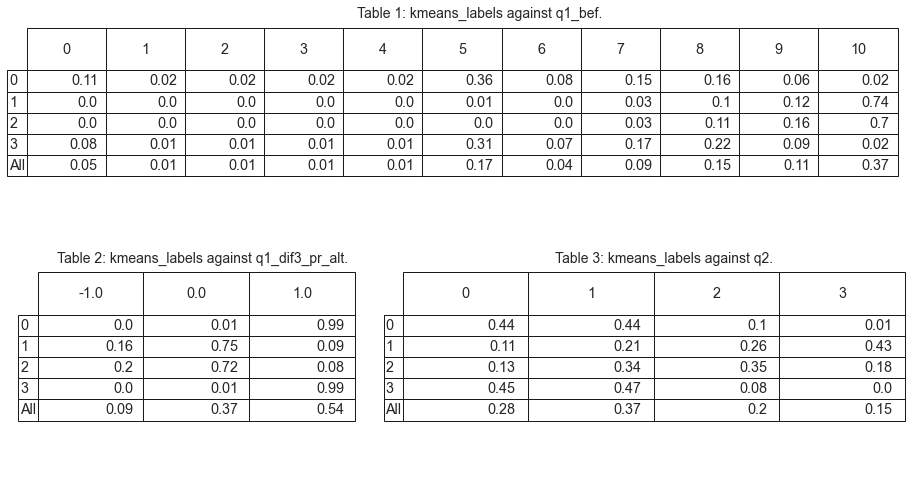

In [45]:
## Another way to make tables.
## Reference: https://stackoverflow.com/a/48744739
## Reference: https://stackoverflow.com/a/45494542

tb1 = pd.crosstab(df['kmeans_labels'], df['q1_bef'], 
                  margins=True, normalize='index').round(2)
tb2 = pd.crosstab(df['kmeans_labels'], df['q1_dif3_pr_alt'], 
                  margins=True, normalize='index').round(2)
tb3 = pd.crosstab(df['kmeans_labels'], df['q2'], 
                  margins=True, normalize='index').round(2)

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(13, 7))
## 2 row x 5 columns grid layout to place subplots.
gs = gridspec.GridSpec(2, 5)

## ax1 taking the 5 columns at the top.
ax1 = fig.add_subplot(gs[0, 0:5])
ax1.set_title('Table 1: kmeans_labels against q1_bef.', fontsize=14)
ax1.axis('off')

cellText = tb1.values
rowLabels = tb1.index
colLabels = tb1.columns
ax1_table = ax1.table(cellText = cellText,
                      rowLabels = rowLabels,
                      colLabels = colLabels,
                      loc = 'best')

cellDict = ax1_table.get_celld()
for i in range(0,len(colLabels)):
    cellDict[(0,i)].set_height(.2) ## Height for column labels.
    for j in range(1,len(cellText)+1):
        cellDict[(j,i)].set_height(.1) ## Height for values.
for k in range(1,len(rowLabels)+1):
    cellDict[(k,-1)].set_height(.1) ## Height for row labels.
#ax1_table.scale(1, 2)
#ax1_table.auto_set_font_size(False)
#ax1_table.set_fontsize(12)

## ax2 taking the first 2 columns at the bottom.
ax2 = fig.add_subplot(gs[1, 0:2])
ax2.set_title('Table 2: kmeans_labels against q1_dif3_pr_alt.', fontsize=14)
ax2.axis('off')

cellText = tb2.values
rowLabels = tb2.index
colLabels = tb2.columns
ax2_table = ax2.table(cellText = cellText,
                      rowLabels = rowLabels,
                      colLabels = colLabels,
                      loc = 'best')

cellDict = ax2_table.get_celld()
for i in range(0,len(colLabels)):
    cellDict[(0,i)].set_height(.2) ## Height for column labels.
    for j in range(1,len(cellText)+1):
        cellDict[(j,i)].set_height(.1) ## Height for values.
for k in range(1,len(rowLabels)+1):
    cellDict[(k,-1)].set_height(.1) ## Height for row labels.
#ax2_table.scale(1, 2)
#ax2_table.auto_set_font_size(False)
#ax2_table.set_fontsize(12)
    
## ax3 taking the last 3 columns at the bottom.
ax3 = fig.add_subplot(gs[1, 2:5])
ax3.set_title('Table 3: kmeans_labels against q2.', fontsize=14)
ax3.axis('off')

cellText = tb3.values
rowLabels = tb3.index
colLabels = tb3.columns
ax3_table = ax3.table(cellText = cellText,
                      rowLabels = rowLabels,
                      colLabels = colLabels,
                      loc = 'best')

cellDict = ax3_table.get_celld()
for i in range(0,len(colLabels)):
    cellDict[(0,i)].set_height(.2) ## Height for column labels.
    for j in range(1,len(cellText)+1):
        cellDict[(j,i)].set_height(.1) ## Height for values.
for k in range(1,len(rowLabels)+1):
    cellDict[(k,-1)].set_height(.1) ## Height for row labels.
#ax3_table.scale(1, 2)
#ax3_table.auto_set_font_size(False)
#ax3_table.set_fontsize(12)    

plt.tight_layout()
plt.show()

<h1><center>THE END!</center></h1>